<a href="https://colab.research.google.com/github/betelmekonnen/Water-Temperature-in-the-Bay/blob/main/Reports_with_Water_Temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import t
from scipy import stats
from IPython.display import display, Math
import statsmodels.api as sm
import statsmodels.formula.api as smf

Mean:  14.14
Sum:  7267.71
Variance:  40.574


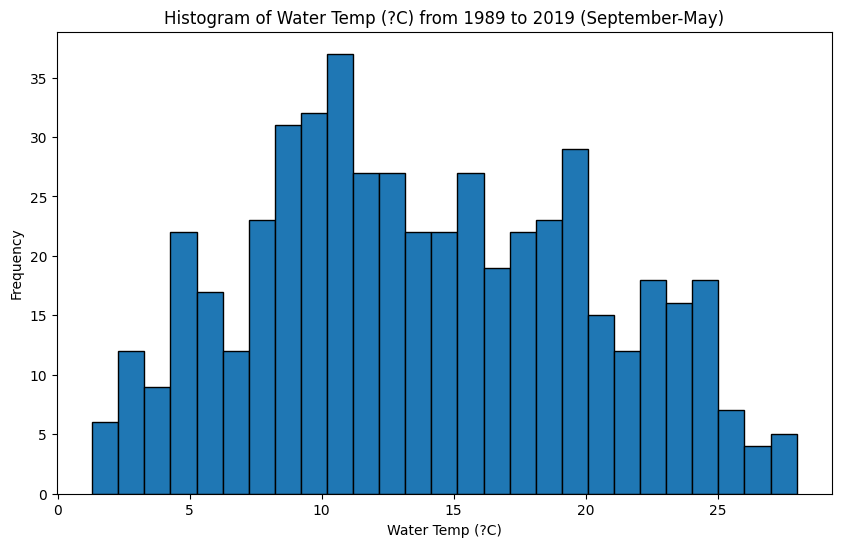

In [ ]:
# Read the file
df = pd.read_csv("/content/BKB_WaterQualityData_2020084.csv")

# Drop unrelated columns
df.drop("Unit_Id", axis=1, inplace=True)
df.drop("Salinity (ppt)", axis=1, inplace=True)
# df.drop("pH (standard units)", axis=1, inplace=True)
df.drop("Secchi Depth (m)", axis=1, inplace=True)
df.drop("Water Depth (m)", axis=1, inplace=True)
df.drop("Air Temp-Celsius", axis=1, inplace=True)
df.drop("Time (24:00)", axis=1, inplace=True)
df.drop("Field_Tech", axis=1, inplace=True)
df.drop("DateVerified", axis=1, inplace=True)
df.drop("WhoVerified", axis=1, inplace=True)
df.drop("Year", axis=1, inplace=True)

# Only include Site_Id="Bay" and remove NaN (blank, invalid, etc.) values
# Also remove blank Read_Date values (those are for the several 1899 samples)
df = df[(df["Site_Id"] == "Bay") & (df["Read_Date"] != "")]
df.dropna(inplace=True)

# Make Read_Date split into Year, Month, Day columns before filtering
df["Year"] = df.apply(lambda row: int(row.Read_Date.split("/")[2]), axis=1)
df["Month"] = df.apply(lambda row: int(row.Read_Date.split("/")[0]), axis=1)
df["Day"] = df.apply(lambda row: int(row.Read_Date.split("/")[1]), axis=1)
df.drop("Read_Date", axis=1, inplace=True)

# Getting rid of outliers
# Remove temperature >32°C for cold months (October to May) but keep September values as they are
df = df[((df["Water Temp (?C)"] <= 32) | (df["Month"] == 9)) &
        (df["Water Temp (?C)"] >= df["Water Temp (?C)"].quantile(0.25) -
         1.5 * (df["Water Temp (?C)"].quantile(0.75) - df["Water Temp (?C)"].quantile(0.25))) &
        (df["Water Temp (?C)"] <= df["Water Temp (?C)"].quantile(0.75) +
         1.5 * (df["Water Temp (?C)"].quantile(0.75) - df["Water Temp (?C)"].quantile(0.25)))]

# Filter data for years between 1989-2019 and months between September-May
df = df[(df["Year"] >= 1989) & (df["Year"] <= 2019) & ((df["Month"] >= 9) | (df["Month"] <= 5))]

#df = df[["Site_Id", "Year", "Month", "Day", "Water Temp (?C)", "AirTemp (C)", "Air Temp (?F)"]]

df = df[["Site_Id", "Year", "Month", "Day", "Water Temp (?C)", "AirTemp (C)", "Air Temp (?F)", "pH (standard units)", "Dissolved Oxygen (mg/L)"]] # Rearrange
# Order the data by Year, Month, Day
df.sort_values(["Year", "Month", "Day"], ascending=[True, True, True], inplace=True)

# Calculate parameter values
all_values = df["Water Temp (?C)"].to_numpy()
print("Mean: ", round(np.mean(all_values), 3))
print("Sum: ", round(np.sum(all_values), 3))
print("Variance: ", round(np.var(all_values), 3))

# Make a histogram
plt.figure(figsize=(10, 6))
plt.hist(df['Water Temp (?C)'], bins=27, edgecolor='black')
plt.title('Histogram of Water Temp (?C) from 1989 to 2019 (September-May)')
plt.xlabel('Water Temp (?C)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df.head(5)

,Site_Id,Year,Month,Day,Water Temp (?C),AirTemp (C),Air Temp (?F),pH (standard units),Dissolved Oxygen (mg/L)
39,Bay,1989,5,18,17.5,20.5,68.9,7.5,12.0
49,Bay,1989,9,14,26.0,26.0,78.8,7.5,6.0
50,Bay,1989,10,25,15.0,19.0,66.2,8.5,7.8
53,Bay,1989,11,27,9.0,4.0,39.2,7.5,10.3
54,Bay,1989,12,11,3.0,3.0,37.4,7.0,10.2


In [ ]:
# Constants to use
N = len(df.index)
mu = np.mean(all_values)
sigma_squared = np.var(all_values)
print(sigma_squared)

print(N)
# Function to get sample size (n) for a given z statistic and r value
def sample_size(z, r):
  d = r*mu
  numerator = (z**2) * sigma_squared
  denominator = d**2
  n = 1 / ((1 / (numerator / denominator)) + (1 / N))

  return n

40.57437661168223
514


In [ ]:
# For CI 90%

sample_size_90_1 = round(sample_size(1.645, 0.074), 3)
sample_size_90_2 = round(sample_size(1.645, 0.087), 3)
sample_size_90_3 = round(sample_size(1.645, 0.10), 3)

print("For CI 90% and r = 0.074: n =", sample_size_90_1)
print("For CI 90% and r = 0.087: n =", sample_size_90_2)
print("For CI 90% and r = 0.10: n =", sample_size_90_3)

For CI 90% and r = 0.074: n = 83.915
For CI 90% and r = 0.087: n = 63.581
For CI 90% and r = 0.10: n = 49.617


In [ ]:
# For CI 95%

sample_size_95_1 = round(sample_size(1.96, 0.074), 3)
sample_size_95_2 = round(sample_size(1.96, 0.087), 3)
sample_size_95_3 = round(sample_size(1.96, 0.10), 3)


print("For CI 95% and r = 0.074: n =", sample_size_95_1)
print("For CI 95% and r = 0.087: n =", sample_size_95_2)
print("For CI 95% and r = 0.10: n =", sample_size_95_3)

For CI 95% and r = 0.074: n = 111.492
For CI 95% and r = 0.087: n = 85.809
For CI 95% and r = 0.10: n = 67.696


In [ ]:
# Conducting SRS for given sample size (n) values for CI = 90%

np.random.seed(42)
population = np.arange(0, N)

# For CI 90% and r = 0.074:
n1_90 = math.ceil(sample_size_90_1)

sample_90_1 = np.random.choice(population, size=n1_90, replace=False)

print("Sample for CI 90% and r = 0.074: ", sample_90_1)

# For CI 90% and r = 0.087:
n2_90 = math.ceil(sample_size_90_2)

sample_90_2 = np.random.choice(population, size=n2_90, replace=False)

print("Sample for CI 90% and r = 0.087: ", sample_90_2)

# For CI 90% and r = 0.10:
n3_90 = math.ceil(sample_size_90_3)

sample_90_3 = np.random.choice(population, size=n3_90, replace=False)

print("Sample for CI 90% and r = 0.10: ", sample_90_3)

Sample for CI 90% and r = 0.074:  [304 497 440 153 499 131 204 508 325 247 362 352 289  84  10 324  78  30
 184 195 222 209 281 208 124 250  76 381 342 323 244 331 140   9  72 399
 486 225  73 177 402  68 155  55 404 298  77 467 317 475  90 238 484  63
 456  70   2 287 341 137 249 194 172  82 452 318  33 425 227   0  11 237
  22 104 296 101  79 428 388  18 176 231 504 132]
Sample for CI 90% and r = 0.087:  [ 15 453 439  31 127 124 442 123  76 493 446  70 152 101 160  26 279 297
 399 475  96 187 260 309 179 207 359 286 138 486 484 130  87 324 406 508
 213 381 369 199 157 346 170 350 327 487 240 244 373 287 497  48  59 115
 340  10 237 511   1  86 230 174 310 460]
Sample for CI 90% and r = 0.10:  [480 313   5  65 508 182 175 473 383 231 198 219  92  27 374 267 446 274
 460 423 239 240 361  90  57  64 211 430  51 406 342 168 244 232 388 271
  49 457 190  29 192 169 370 252 159 512  67 483 258 226]


In [ ]:
# Conducting SRS for given sample size (n) values for CI = 95%

np.random.seed(42)
population = np.arange(0, N)

# For CI 90% and r = 0.074:
n1_95 = math.ceil(sample_size_95_1)

sample_95_1 = np.random.choice(population, size=n1_95, replace=False)

print("Sample for CI 95% and r = 0.074: ", sample_95_1)

# For CI 90% and r = 0.087:
n2_95 = math.ceil(sample_size_95_2)

sample_95_2 = np.random.choice(population, size=n2_95, replace=False)

print("Sample for CI 95% and r = 0.087: ", sample_95_2)

# For CI 95% and r = 0.10:
n3_95 = math.ceil(sample_size_95_3)

sample_95_3 = np.random.choice(population, size=n3_95, replace=False)

print("Sample for CI 95% and r = 0.10: ", sample_95_3)

Sample for CI 95% and r = 0.074:  [304 497 440 153 499 131 204 508 325 247 362 352 289  84  10 324  78  30
 184 195 222 209 281 208 124 250  76 381 342 323 244 331 140   9  72 399
 486 225  73 177 402  68 155  55 404 298  77 467 317 475  90 238 484  63
 456  70   2 287 341 137 249 194 172  82 452 318  33 425 227   0  11 237
  22 104 296 101  79 428 388  18 176 231 504 132  39 471  46 356 277 361
  93 377 203 449 148 220  69 253 397 167 275 505 509 320 329 173 272 493
 182 268 351 117]
Sample for CI 95% and r = 0.087:  [ 15 453 439  31 127 124 442 123  76 493 446  70 152 101 160  26 279 297
 399 475  96 187 260 309 179 207 359 286 138 486 484 130  87 324 406 508
 213 381 369 199 157 346 170 350 327 487 240 244 373 287 497  48  59 115
 340  10 237 511   1  86 230 174 310 460 218  30 432 398  54  23 256 448
   3 422 188 171 391 273  32 405 478 485  58 351 203 215]
Sample for CI 95% and r = 0.10:  [480 313   5  65 508 182 175 473 383 231 198 219  92  27 374 267 446 274
 460 423 239 240 361

In [ ]:
# Estimating the Parameter with Sample for 90% CI

sampled_values_90_1 = df['Water Temp (?C)'].iloc[sample_90_1]
sampled_values_90_2 = df['Water Temp (?C)'].iloc[sample_90_2]
sampled_values_90_3 = df['Water Temp (?C)'].iloc[sample_90_3]

sample_mean_90_1 = round(np.mean(sampled_values_90_1), 3)
sample_mean_90_2 = round(np.mean(sampled_values_90_2), 3)
sample_mean_90_3 = round(np.mean(sampled_values_90_3), 3)

print("Sample Mean for 90% CI with r = 0.074:", sample_mean_90_1)
print("Sample Mean for 90% CI with r = 0.087:", sample_mean_90_2)
print("Sample Mean for 90% CI with r = 0.10:", sample_mean_90_3)

Sample Mean for 90% CI with r = 0.074: 14.839
Sample Mean for 90% CI with r = 0.087: 13.667
Sample Mean for 90% CI with r = 0.10: 14.016


In [ ]:
# Estimating the Parameter with Sample for 95% CI

sampled_values_95_1 = df['Water Temp (?C)'].iloc[sample_95_1]
sampled_values_95_2 = df['Water Temp (?C)'].iloc[sample_95_2]
sampled_values_95_3 = df['Water Temp (?C)'].iloc[sample_95_3]

sample_mean_95_1 = round(np.mean(sampled_values_95_1), 3)
sample_mean_95_2 = round(np.mean(sampled_values_95_2), 3)
sample_mean_95_3 = round(np.mean(sampled_values_95_3), 3)

print("Sample Mean for 95% CI with r = 0.074:", sample_mean_95_1)
print("Sample Mean for 95% CI with r = 0.087:", sample_mean_95_2)
print("Sample Mean for 95% CI with r = 0.10:", sample_mean_95_3)

Sample Mean for 95% CI with r = 0.074: 14.482
Sample Mean for 95% CI with r = 0.087: 13.441
Sample Mean for 95% CI with r = 0.10: 13.918


In [ ]:
# Calculating Variance for given sample size (n) values for CI = 90%

estimator_variance_90_1 = round(((N-sample_size_90_1)*round(np.var(sampled_values_90_1), 2))/(N*sample_size_90_1), 3)
estimator_variance_90_2 = round(((N-sample_size_90_2)*round(np.var(sampled_values_90_2), 2))/(N*sample_size_90_2), 3)
estimator_variance_90_3 = round(((N-sample_size_90_3)*round(np.var(sampled_values_90_3), 2))/(N*sample_size_90_3), 3)

print("Variance of estimator for 90% CI with r = 0.074:", estimator_variance_90_1)
print("Variance of estimator for 90% CI with r = 0.087:", estimator_variance_90_2)
print("Variance of estimator for 90% CI with r = 0.10:", estimator_variance_90_3)

Variance of estimator for 90% CI with r = 0.074: 0.34
Variance of estimator for 90% CI with r = 0.087: 0.603
Variance of estimator for 90% CI with r = 0.10: 0.689


In [ ]:
# Calculating Variance for given sample size (n) values for CI = 95%

estimator_variance_95_1 = round(((N-sample_size_95_1)*round(np.var(sampled_values_95_1), 2))/(N*sample_size_95_1), 3)
estimator_variance_95_2 = round(((N-sample_size_95_2)*round(np.var(sampled_values_95_2), 2))/(N*sample_size_95_2), 3)
estimator_variance_95_3 = round(((N-sample_size_95_3)*round(np.var(sampled_values_95_3), 2))/(N*sample_size_95_3), 3)

print("Variance of estimator for 95% CI with r = 0.074:", estimator_variance_95_1)
print("Variance of estimator for 95% CI with r = 0.087:", estimator_variance_95_2)
print("Variance of estimator for 95% CI with r = 0.10:", estimator_variance_95_3)

Variance of estimator for 95% CI with r = 0.074: 0.231
Variance of estimator for 95% CI with r = 0.087: 0.393
Variance of estimator for 95% CI with r = 0.10: 0.495


In [ ]:
# 90% CI for various estimators

confidence_level = 0.90
alpha = 1 - confidence_level

t_critical_90_1 = t.ppf(1 - alpha / 2, df= sample_size_90_1 - 1)

lower_90_CI_1 = round((sample_mean_90_1-(t_critical_90_1 * np.sqrt(estimator_variance_90_1))), 3)
upper_90_CI_1 = round((sample_mean_90_1+(t_critical_90_1 * np.sqrt(estimator_variance_90_1))), 3)

print("90% CI for r = 0.074: ", {lower_90_CI_1}, {upper_90_CI_1})

t_critical_90_2 = t.ppf(1 - alpha / 2, df= sample_size_90_2 - 1)

lower_90_CI_2 = round((sample_mean_90_1-(t_critical_90_2 * np.sqrt(estimator_variance_90_2))), 3)
upper_90_CI_2 = round((sample_mean_90_1+(t_critical_90_2 * np.sqrt(estimator_variance_90_2))), 3)

print("90% CI for r = 0.087: ", {lower_90_CI_2}, {upper_90_CI_2})

t_critical_90_3 = t.ppf(1 - alpha / 2, df= sample_size_90_3 - 1)

lower_90_CI_3 = round((sample_mean_90_1-(t_critical_90_3 * np.sqrt(estimator_variance_90_3))), 3)
upper_90_CI_3 = round((sample_mean_90_1+(t_critical_90_3 * np.sqrt(estimator_variance_90_3))), 3)

print("90% CI for r = 0.10: ", {lower_90_CI_3}, {upper_90_CI_3})

90% CI for r = 0.074:  {13.869} {15.809}
90% CI for r = 0.087:  {13.543} {16.135}
90% CI for r = 0.10:  {13.447} {16.231}


In [ ]:
# 95% CI for various estimators

confidence_level = 0.95
alpha = 1 - confidence_level

t_critical_95_1 = t.ppf(1 - alpha / 2, df= sample_size_95_1 - 1)

lower_95_CI_1 = round((sample_mean_95_1-(t_critical_95_1 * np.sqrt(estimator_variance_95_1))), 3)
upper_95_CI_1 = round((sample_mean_95_1+(t_critical_95_1 * np.sqrt(estimator_variance_95_1))), 3)

print("95% CI for r = 0.074: ", {lower_95_CI_1}, {upper_95_CI_1})

t_critical_95_2 = t.ppf(1 - alpha / 2, df= sample_size_90_2 - 1)

lower_95_CI_2 = round((sample_mean_95_1-(t_critical_95_2 * np.sqrt(estimator_variance_95_2))), 3)
upper_95_CI_2 = round((sample_mean_95_1+(t_critical_95_2 * np.sqrt(estimator_variance_95_2))), 3)

print("95% CI for r = 0.087: ", {lower_95_CI_2}, {upper_95_CI_2})

t_critical_95_3 = t.ppf(1 - alpha / 2, df= sample_size_90_3 - 1)

lower_95_CI_3 = round((sample_mean_95_1-(t_critical_95_3 * np.sqrt(estimator_variance_95_3))), 3)
upper_95_CI_3 = round((sample_mean_95_1+(t_critical_95_3 * np.sqrt(estimator_variance_95_3))), 3)

print("95% CI for r = 0.10: ", {lower_95_CI_3}, {upper_95_CI_3})

95% CI for r = 0.074:  {13.53} {15.434}
95% CI for r = 0.087:  {13.229} {15.735}
95% CI for r = 0.10:  {13.068} {15.896}


# Report 3  


In [ ]:
# Population Size: N = 514
# Sample sizen: n = 85

N = len(df.index)
print(N)
n = 85

# Correlation between the two variables
correlation_airtemp_f = df['Water Temp (?C)'].corr(df['Air Temp (?F)'])

print(correlation_airtemp_f)

514
0.9018082455783347


## Air Temp
### Problem 1 - Proportional Probabilities

In [ ]:
# Getting all the values in the Air Temp (?F) Column
air_temp_values = df["Air Temp (?F)"].to_numpy()

# Calculating the total sum of the air temperature values
total_air_temp = np.sum(air_temp_values)

# Computing probabilities proportional to air temperature values
probabilities = air_temp_values / total_air_temp

# Adding probabilities to dataframe
df["AirTemp_Probabilities"] = probabilities

# First five rows in the dataframe
print(df.head(5))

# Seed for reproducibility
np.random.seed(42)

# Performing random sampling (with replacement)
sample = np.random.choice(df["Water Temp (?C)"], size=n, replace=True, p=probabilities)

print(sample[:10])

   Site_Id  Year  Month  Day  Water Temp (?C)  AirTemp (C)  Air Temp (?F)  \
39     Bay  1989      5   18             17.5         20.5           68.9   
49     Bay  1989      9   14             26.0         26.0           78.8   
50     Bay  1989     10   25             15.0         19.0           66.2   
53     Bay  1989     11   27              9.0          4.0           39.2   
54     Bay  1989     12   11              3.0          3.0           37.4   

    pH (standard units)  Dissolved Oxygen (mg/L)  AirTemp_Probabilities  
39                  7.5                     12.0               0.002363  
49                  7.5                      6.0               0.002702  
50                  8.5                      7.8               0.002270  
53                  7.5                     10.3               0.001344  
54                  7.0                     10.2               0.001283  
[15.5  4.  10.  11.  12.  12.   9.  13.   6.  21. ]


### Problems 2, 3. Sample n=85, HH, var, and CI

In [ ]:
# Seed for reproducibility
np.random.seed(42)

# Sample indices from the dataframe based on AirTemp probabilities (with replacement)
sample_indices = np.random.choice(df.index, size=n, replace=True, p=probabilities)

# Extracting the corresponding water temperature values and sampling probabilities for the sampled units
sampled_values = df.loc[sample_indices, "Water Temp (?C)"].to_numpy()
sampled_probabilities = df.loc[sample_indices, "AirTemp_Probabilities"].to_numpy()
# Computing the Hansen-Hurwitz estimator
hh_estimator = np.mean(sampled_values / sampled_probabilities)

#Our parameter of interest is the population mean and an unbiased estimator for this using Hansen-Hurwitz estimator is
mu_hat_p = hh_estimator / N

display(Math(r'{\hat{\tau}}_{p} = ' + str(round(hh_estimator, 3))))

display(Math(r'{\hat{\mu}}_{p} = ' + str(round(mu_hat_p, 3))))


# Estimator of variance
var_hat = (1/(n*(n-1)))*(np.sum(((sampled_values / sampled_probabilities)-(hh_estimator))**2))
display(Math(r'{\hat{var}}({\hat{\tau}}_{p}) = ' + str(round(var_hat, 3))))

var_hat_mu = var_hat/(N**2)
display(Math(r'{\hat{var}}({\hat{\mu}}_{p}) = ' + str(round(var_hat_mu, 3))))


# True Variance
tau = np.sum(df["Water Temp (?C)"].to_numpy())
var_true = 0
for i in df.index:
  pi = df.loc[i, "AirTemp_Probabilities"]
  yi = df.loc[i, "Water Temp (?C)"]
  var_true += pi*(((yi)/(pi)-tau)**2)
var_true = var_true/(N*N*n)
print("HH Var True:", round(var_true, 4))
# # Used 95% CI giving alpha of 0.05
alpha = 0.05

# # Getting t distribution crictal value
t_critical_95 = t.ppf(1 - alpha / 2, df = n - 1)

# # Calculating the lower and upper bounds of the confidence interval
lower_95_CI = round((mu_hat_p-(t_critical_95 * np.sqrt(var_hat_mu))), 3)
upper_95_CI = round((mu_hat_p+(t_critical_95 * np.sqrt(var_hat_mu))), 3)

print("95% CI:", {lower_95_CI}, {upper_95_CI})

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

HH Var True: 0.1797
95% CI: {12.867} {14.583}


### Problem 4. πi

In [ ]:
# Add inclusion probabilities to the whole population
inclusion_probabilities = 1 - (1 - probabilities) ** n
df.loc[:, "Inclusion_Probabilities"] = inclusion_probabilities

# Creating a copy to show just the sampled data
df_sampled = df.loc[sample_indices].copy()

# Adding the inclusion probabilities to the sampled dataframe
sampled_inclusion_probabilities = 1 - (1 - sampled_probabilities) ** n
df_sampled["Inclusion_Probabilities"] = sampled_inclusion_probabilities

# fix df_sampled index
df_sampled.reset_index(drop=True, inplace=True)

# Printing first five values of sampled dataframe
print(df_sampled.head(5))

  Site_Id  Year  Month  Day  Water Temp (?C)  AirTemp (C)  Air Temp (?F)  \
0     Bay  1996     10    5             15.5    17.200000          62.96   
1     Bay  2018      1   31              4.0    -1.111111          30.00   
2     Bay  2010      3   16             10.0     6.666667          44.00   
3     Bay  2005     12    1             11.0     6.111111          43.00   
4     Bay  1992     10   19             12.0    10.000000          50.00   

   pH (standard units)  Dissolved Oxygen (mg/L)  AirTemp_Probabilities  \
0                  7.2                      9.9               0.002159   
1                  7.0                      8.0               0.001029   
2                  6.5                      7.9               0.001509   
3                  6.5                      7.2               0.001475   
4                  7.5                      9.8               0.001715   

   Inclusion_Probabilities  
0                 0.167841  
1                 0.083779  
2          

### Problem 5. HT, est variance, and true variance

In [ ]:
# pi_ij formula that we will use for HT and g-uneq
def pi_ij(i, j, p_list, pi_list):
  return pi_list[i] + pi_list[j] - 1 + ((1 - p_list[i] - p_list[j]) ** n)

# Getting the unique sample indices from the previously sampled indices
unique_sample_indices = np.unique(sample_indices)
df_sampled = df.loc[unique_sample_indices].copy()
print("Size of Original Sample", len(sample_indices))
print("Size of Sample", len(unique_sample_indices))
# Extracting the unique sampled water temperature values (Water Temp (?C)) from the dataframe
# y_i, i in V
unique_sampled_values = df_sampled.loc[:, "Water Temp (?C)"].to_numpy()

# Extracting the corresponding unique inclusion probabilities from the dataframe for the unique sample indices
# pi_i, i in V
unique_sampled_inclusion_probabilities = df_sampled.loc[:, "Inclusion_Probabilities"].to_numpy()

# Extracting the corresponding unique inclusion probabilities from the dataframe for the unique sample indices
# p_i, i in V
unique_sampled_probabilities = df_sampled.loc[:, "AirTemp_Probabilities"].to_numpy()

# Calculating the Horvitz-Thompson estimator
ht_estimator = np.sum(unique_sampled_values / unique_sampled_inclusion_probabilities)

# The unbiased estimator for the population mean is mu_hat_pi
mu_hat_pi = ht_estimator / N

display(Math(r'{\hat{\tau}}_{\pi} = ' + str(round(ht_estimator, 3))))
display(Math(r'{\hat{\mu}}_{\pi} = ' + str(round(mu_hat_pi, 3))))

# Calculating the estimated variance of the Horvitz-Thompson estimator using the sampled values and inclusion probabilities
evar_ht = np.sum(((1 - unique_sampled_inclusion_probabilities) / (unique_sampled_inclusion_probabilities ** 2)) * (unique_sampled_values ** 2))
for i in range(len(df_sampled)):
  for j in range(len(df_sampled)):
    if i != j:
      evar_ht += (pi_ij(i, j, unique_sampled_probabilities, unique_sampled_inclusion_probabilities) - (unique_sampled_inclusion_probabilities[i] * unique_sampled_inclusion_probabilities[j])) \
      / (unique_sampled_inclusion_probabilities[i] * unique_sampled_inclusion_probabilities[j]) \
      * (unique_sampled_values[i] * unique_sampled_values[j] / pi_ij(i, j, unique_sampled_probabilities, unique_sampled_inclusion_probabilities))

display(Math(r'{\hat{var}}({\hat{\tau}}_{\pi}) = ' + str(round(evar_ht, 3))))
evar_ht_mu = evar_ht / (N ** 2)
display(Math(r'{\hat{var}}({\hat{\mu}}_{\pi}) = ' + str(round(evar_ht_mu, 3))))

# Used 95% CI giving alpha of 0.05
# Getting t distribution crictal value
alpha = 0.05
t_critical_95 = t.ppf(1 - alpha / 2, df=len(unique_sample_indices)-1)
print("t_critical_95 : ", t_critical_95)
# Calculating the lower and upper bounds of the confidence interval
lower_95_CI = round(mu_hat_pi - (t_critical_95 * np.sqrt(evar_ht_mu)), 3)
upper_95_CI = round(mu_hat_pi + (t_critical_95 * np.sqrt(evar_ht_mu)), 3)

print("95% CI:", {lower_95_CI}, {upper_95_CI})

### Calculate the true variance of HT
# yi for pop
population_values = df.loc[:, "Water Temp (?C)"].to_numpy()
# pi_i for pop
population_inclusion_probabilities = df.loc[:, "Inclusion_Probabilities"].to_numpy()
# p_i for pop
population_probabilities = df.loc[:, "AirTemp_Probabilities"].to_numpy()
# tau for pop
population_tau = np.sum(population_values)

# calculate the variance
var_ht = np.sum(((1 - population_inclusion_probabilities) / population_inclusion_probabilities)*(population_values ** 2))
for i in range(0, len(population_values)):
  for j in range(0, len(population_values)):
    if j != i:
      var_ht += ((pi_ij(i, j, population_probabilities, population_inclusion_probabilities) - (population_inclusion_probabilities[i] * population_inclusion_probabilities[j])) \
      / (population_inclusion_probabilities[i] * population_inclusion_probabilities[j])) \
      * (population_values[i] * population_values[j])

var_ht_mu = var_ht / (N ** 2)

display(Math(r'{var}({\hat{\mu}}_{\pi}) = ' + str(round(var_ht_mu, 3))))

Size of Original Sample 85
Size of Sample 77


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

t_critical_95 :  1.9916726096446642
95% CI: {12.132} {14.533}


<IPython.core.display.Math object>

### Problem 6. G Uneq

In [ ]:
# Generalized Unequal Probability Estimator (μg)
gup_estimator = np.sum(unique_sampled_values / unique_sampled_inclusion_probabilities) / np.sum(1 / unique_sampled_inclusion_probabilities)

display(Math(r'{\hat{\mu}}_{g} = ' + str(round(gup_estimator, 3))))

# Estimated variance calculation
evar_gu = np.sum(((1 - unique_sampled_inclusion_probabilities) / (unique_sampled_inclusion_probabilities ** 2)) * ((unique_sampled_values - gup_estimator) ** 2))
for i in range(len(df_sampled)):
  for j in range(len(df_sampled)):
    if i != j:
      evar_gu += (pi_ij(i, j, unique_sampled_probabilities, unique_sampled_inclusion_probabilities) - (unique_sampled_inclusion_probabilities[i] * unique_sampled_inclusion_probabilities[j])) \
      / (unique_sampled_inclusion_probabilities[i] * unique_sampled_inclusion_probabilities[j]) \
      * ((unique_sampled_values[i] - gup_estimator) * (unique_sampled_values[j] - gup_estimator) / pi_ij(i, j, unique_sampled_probabilities, unique_sampled_inclusion_probabilities))


display(Math(r'{\hat{var}}({\hat{\tau}}_{g}) = ' + str(round(evar_gu, 3))))

#evar_gu_mu = evar_ht / (N ** 2)
evar_gu_mu = evar_gu / (N ** 2)

display(Math(r'{\hat{var}}({\hat{\mu}}_{g}) = ' + str(round(evar_gu_mu, 3))))

# Confidence Interval (CI)
lower_95_CI_gup = round(gup_estimator - (t_critical_95 * np.sqrt(evar_gu_mu)), 3)
upper_95_CI_gup = round(gup_estimator + (t_critical_95 * np.sqrt(evar_gu_mu)), 3)

print("95% CI for Generalized Estimator:", {lower_95_CI_gup}, {upper_95_CI_gup})

# True variance calculation
true_mu = 14.227

var_gu = np.sum(((1 - population_inclusion_probabilities) / population_inclusion_probabilities)*((population_values - true_mu) ** 2))
for i in range(0, len(population_values)):
  for j in range(0, len(population_values)):
    if j != i:
      var_gu += ((pi_ij(i, j, population_probabilities, population_inclusion_probabilities) - (population_inclusion_probabilities[i] * population_inclusion_probabilities[j])) \
      / (population_inclusion_probabilities[i] * population_inclusion_probabilities[j])) \
      * ((population_values[i] - true_mu) * (population_values[j] - true_mu))

var_gu_mu = var_gu / (N ** 2)

display(Math(r'{var}({\hat{\mu}}_{g}) = ' + str(round(var_gu_mu, 3))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

95% CI for Generalized Estimator: {11.896} {14.802}


<IPython.core.display.Math object>

### Problem 7. Best estimator based on estimated variance of the estimator

In [ ]:
# Comparing variances of the three estimators

estimators_variances = {
    "Hansen-Hurwitz": var_hat_mu,
    "Horvitz-Thompson": evar_ht_mu,
    "Generalized": evar_gu_mu
}

# Choose the estimator with the smallest variance
best_estimator = min(estimators_variances, key=estimators_variances.get)
print("The best estimator based on variance is:", best_estimator)


The best estimator based on variance is: Hansen-Hurwitz


### Problem 8. Already integrated into the individual estimator calculation sections

### Problem 9. 1-8 except with a different variable (pH)

In [ ]:
# Doing everything over but using PH as the variable

In [ ]:
# Population Size: N = 514
# Sample sizen: n = 85

N = 514
n = 85

# Correlation between the two variables
correlation_airtemp_f = df['Water Temp (?C)'].corr(df['pH (standard units)'])

print(correlation_airtemp_f)

0.23428598021085925


In [ ]:
# Getting all the values in the pH (standard units) Column
ph_values = df["pH (standard units)"].to_numpy()

# Calculating the total sum of the PH values
total_ph = np.sum(ph_values)

# Computing probabilities proportional to PH values
PH_probabilities = ph_values / total_ph

# Adding probabilities to dataframe
df["PH_Probabilities"] = PH_probabilities

# First five rows in the dataframe
print(df.head(5))

# Seed for reproducibility
np.random.seed(42)

# Performing random sampling (with replacement)
sample = np.random.choice(df["Water Temp (?C)"], size=n, replace=True, p=PH_probabilities)

print(sample[:10])

   Site_Id  Year  Month  Day  Water Temp (?C)  AirTemp (C)  Air Temp (?F)  \
39     Bay  1989      5   18             17.5         20.5           68.9   
49     Bay  1989      9   14             26.0         26.0           78.8   
50     Bay  1989     10   25             15.0         19.0           66.2   
53     Bay  1989     11   27              9.0          4.0           39.2   
54     Bay  1989     12   11              3.0          3.0           37.4   

    pH (standard units)  Dissolved Oxygen (mg/L)  AirTemp_Probabilities  \
39                  7.5                     12.0               0.002363   
49                  7.5                      6.0               0.002702   
50                  8.5                      7.8               0.002270   
53                  7.5                     10.3               0.001344   
54                  7.0                     10.2               0.001283   

    Inclusion_Probabilities  PH_Probabilities  
39                 0.182158          0

In [ ]:
# Seed for reproducibility
np.random.seed(42)

# Sample indices from the dataframe based on PH probabilities (with replacement)
sample_indices = np.random.choice(df.index, size=n, replace=True, p=PH_probabilities)

# Extracting the corresponding water temperature values and sampling probabilities for the sampled units
sampled_values = df.loc[sample_indices, "Water Temp (?C)"].to_numpy()
sampled_probabilities = df.loc[sample_indices, "PH_Probabilities"].to_numpy()

# Computing the Hansen-Hurwitz estimator
hh_estimator = np.mean(sampled_values / sampled_probabilities)

#Our parameter of interest is the population mean and an unbiased estimator for this using Hansen-Hurwitz estimator is
mu_hat_p = hh_estimator / N

display(Math(r'{\hat{\tau}}_{p} = ' + str(round(hh_estimator, 3))))

display(Math(r'{\hat{\mu}}_{p} = ' + str(round(mu_hat_p, 3))))


# Estimator of variance
var_hat = (1/(n*(n-1)))*(np.sum(((sampled_values / sampled_probabilities)-(hh_estimator))**2))
display(Math(r'{\hat{var}}({\hat{\tau}}_{p}) = ' + str(round(var_hat, 3))))
var_hat_mu = var_hat/(N**2)

display(Math(r'{\hat{var}}({\hat{\mu}}_{p}) = ' + str(round(var_hat_mu, 3))))


# True Variance
tau = np.sum(df["Water Temp (?C)"].to_numpy())
var_true = 0
for i in df.index:
  pi = df.loc[i, "PH_Probabilities"]
  yi = df.loc[i, "Water Temp (?C)"]
  var_true += pi*(((yi)/(pi)-tau)**2)
var_true = var_true/(N*N*n)
print("HH Var True:", round(var_true, 4))
# # Used 95% CI giving alpha of 0.05
alpha = 0.05

# # Getting t distribution crictal value
t_critical_95 = t.ppf(1 - alpha / 2, df = n - 1)

# # Calculating the lower and upper bounds of the confidence interval
lower_95_CI = round((mu_hat_p-(t_critical_95 * np.sqrt(var_hat_mu))), 3)
upper_95_CI = round((mu_hat_p+(t_critical_95 * np.sqrt(var_hat_mu))), 3)

print("95% CI:", {lower_95_CI}, {upper_95_CI})

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

HH Var True: 0.4535
95% CI: {13.674} {16.75}


In [ ]:
# Getting sampled inclusion probabilities
inclusion_probabilities = 1 - (1 - PH_probabilities) ** n
df.loc[:, "Inclusion_Probabilities"] = inclusion_probabilities


# Creating a copy to show just the sampled data
df_sampled = df.loc[sample_indices].copy()


# Adding the inclusion probabilities to the sampled dataframe
sampled_inclusion_probabilities = 1 - (1 - sampled_probabilities) ** n
df_sampled["Inclusion_Probabilities"] = sampled_inclusion_probabilities


# fix df_sampled index
df_sampled.reset_index(drop=True, inplace=True)


# Printing first five values of sampled dataframe
print(df_sampled.head(5))

  Site_Id  Year  Month  Day  Water Temp (?C)  AirTemp (C)  Air Temp (?F)  \
0     Bay  1996      4   22             21.0    22.000000           71.6   
1     Bay  2017     11    8             16.0    11.111111           52.0   
2     Bay  2010      1    7              4.0    -1.111111           30.0   
3     Bay  2005     10    7             24.0    22.222222           72.0   
4     Bay  1992      9   14             19.5    22.000000           71.6   

   pH (standard units)  Dissolved Oxygen (mg/L)  AirTemp_Probabilities  \
0                  8.2                      9.2               0.002456   
1                  7.0                      6.6               0.001783   
2                  6.5                      7.0               0.001029   
3                  6.5                      5.3               0.002469   
4                  8.0                      9.2               0.002456   

   Inclusion_Probabilities  PH_Probabilities  
0                 0.170630          0.002199  
1   

In [ ]:
# pi_ij formula that we will use for HT and g-uneq
def pi_ij(i, j, p_list, pi_list):
  return pi_list[i] + pi_list[j] - 1 + ((1 - p_list[i] - p_list[j]) ** n)

# Getting the unique sample indices from the previously sampled indices
unique_sample_indices = np.unique(sample_indices)

df_sampled = df.loc[unique_sample_indices].copy()
# Extracting the unique sampled water temperature values (Water Temp (?C)) from the dataframe
# y_i, i in V
unique_sampled_values = df_sampled.loc[:, "Water Temp (?C)"].to_numpy()

# Extracting the corresponding unique inclusion probabilities from the dataframe for the unique sample indices
# pi_i, i in V
unique_sampled_inclusion_probabilities = df_sampled.loc[:, "Inclusion_Probabilities"].to_numpy()

# Extracting the corresponding unique inclusion probabilities from the dataframe for the unique sample indices
# p_i, i in V
unique_sampled_probabilities = df_sampled.loc[:, "PH_Probabilities"].to_numpy()

# Calculating the Horvitz-Thompson estimator
ht_estimator = np.sum(unique_sampled_values / unique_sampled_inclusion_probabilities)

# The unbiased estimator for the population mean is mu_hat_pi
mu_hat_pi = ht_estimator / N

display(Math(r'{\hat{\tau}}_{\pi} = ' + str(round(ht_estimator, 3))))
display(Math(r'{\hat{\mu}}_{\pi} = ' + str(round(mu_hat_pi, 3))))

# Calculating the estimated variance of the Horvitz-Thompson estimator using the sampled values and inclusion probabilities
evar_ht = np.sum(((1 - unique_sampled_inclusion_probabilities) / (unique_sampled_inclusion_probabilities ** 2)) * (unique_sampled_values ** 2))
for i in range(len(df_sampled)):
  for j in range(len(df_sampled)):
    if i != j:
      evar_ht += (pi_ij(i, j, unique_sampled_probabilities, unique_sampled_inclusion_probabilities) - (unique_sampled_inclusion_probabilities[i] * unique_sampled_inclusion_probabilities[j])) \
      / (unique_sampled_inclusion_probabilities[i] * unique_sampled_inclusion_probabilities[j]) \
      * (unique_sampled_values[i] * unique_sampled_values[j] / pi_ij(i, j, unique_sampled_probabilities, unique_sampled_inclusion_probabilities))

display(Math(r'{\hat{var}}({\hat{\tau}}_{\pi}) = ' + str(round(evar_ht, 3))))

evar_ht_mu = evar_ht / (N ** 2)

display(Math(r'{\hat{var}}({\hat{\mu}}_{\pi}) = ' + str(round(evar_ht_mu, 3))))

# Used 95% CI giving alpha of 0.05
# Getting t distribution crictal value
alpha = 0.05
t_critical_95 = t.ppf(1 - alpha / 2, df = len(unique_sampled_values) - 1)

# Calculating the lower and upper bounds of the confidence interval
lower_95_CI = round(mu_hat_pi - (t_critical_95 * np.sqrt(evar_ht_mu)), 3)
upper_95_CI = round(mu_hat_pi + (t_critical_95 * np.sqrt(evar_ht_mu)), 3)

print("95% CI:", {lower_95_CI}, {upper_95_CI})

### Calculate the true variance of HT
# yi for pop
population_values = df.loc[:, "Water Temp (?C)"].to_numpy()
# pi_i for pop
population_inclusion_probabilities = df.loc[:, "Inclusion_Probabilities"].to_numpy()
# p_i for pop
population_probabilities = df.loc[:, "PH_Probabilities"].to_numpy()
# tau for pop
population_tau = np.sum(population_values)

# calculate the variance
var_ht = np.sum(((1 - population_inclusion_probabilities) / population_inclusion_probabilities)*(population_values ** 2))
for i in range(0, len(population_values)):
  for j in range(0, len(population_values)):
    if j != i:
      var_ht += ((pi_ij(i, j, population_probabilities, population_inclusion_probabilities) - (population_inclusion_probabilities[i] * population_inclusion_probabilities[j])) \
      / (population_inclusion_probabilities[i] * population_inclusion_probabilities[j])) \
      * (population_values[i] * population_values[j])

var_ht_mu = var_ht / (N ** 2)

display(Math(r'{var}({\hat{\mu}}_{\pi}) = ' + str(round(var_ht_mu, 3))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

95% CI: {13.024} {16.507}


<IPython.core.display.Math object>

In [ ]:
# Generalized Unequal Probability Estimator (μg)
unique_sample_indices = np.unique(sample_indices)

df_sampled = df.loc[unique_sample_indices].copy()

gup_estimator = np.sum(unique_sampled_values / unique_sampled_inclusion_probabilities) / np.sum(1 / unique_sampled_inclusion_probabilities)

display(Math(r'{\hat{\mu}}_{g} = ' + str(round(gup_estimator, 3))))

# Estimated variance calculation
evar_gu = np.sum(((1 - unique_sampled_inclusion_probabilities) / (unique_sampled_inclusion_probabilities ** 2)) * ((unique_sampled_values - gup_estimator) ** 2))
for i in range(len(df_sampled)):
  for j in range(len(df_sampled)):
    if i != j:
      evar_gu += (pi_ij(i, j, unique_sampled_probabilities, unique_sampled_inclusion_probabilities) - (unique_sampled_inclusion_probabilities[i] * unique_sampled_inclusion_probabilities[j])) \
      / (unique_sampled_inclusion_probabilities[i] * unique_sampled_inclusion_probabilities[j]) \
      * ((unique_sampled_values[i] - gup_estimator) * (unique_sampled_values[j] - gup_estimator) / pi_ij(i, j, unique_sampled_probabilities, unique_sampled_inclusion_probabilities))

display(Math(r'{\hat{var}}({\hat{\tau}}_{g}) = ' + str(round(evar_gu, 3))))

# evar_gu_mu = evar_ht / (N ** 2)
evar_gu_mu = evar_gu / (N ** 2)

display(Math(r'{\hat{var}}({\hat{\mu}}_{g}) = ' + str(round(evar_gu_mu, 3))))

# Confidence Interval (CI)
lower_95_CI_gup = round(gup_estimator - (t_critical_95 * np.sqrt(evar_gu_mu)), 3)
upper_95_CI_gup = round(gup_estimator + (t_critical_95 * np.sqrt(evar_gu_mu)), 3)

print("95% CI for Generalized Estimator:", {lower_95_CI_gup}, {upper_95_CI_gup})
#evar_gu_mu = evar_ht / (N ** 2)
# True variance calculation
true_mu = 14.227
var_gu = np.sum(((1 - population_inclusion_probabilities) / population_inclusion_probabilities)*((population_values - true_mu) ** 2))
for i in range(0, len(population_values)):
  for j in range(0, len(population_values)):
    if j != i:
      var_gu += ((pi_ij(i, j, population_probabilities, population_inclusion_probabilities) - (population_inclusion_probabilities[i] * population_inclusion_probabilities[j])) \
      / (population_inclusion_probabilities[i] * population_inclusion_probabilities[j])) \
      * ((population_values[i] - true_mu) * (population_values[j] - true_mu))

var_gu_mu = var_gu / (N ** 2)

display(Math(r'{var}({\hat{\mu}}_{g}) = ' + str(round(var_gu_mu, 3))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

95% CI for Generalized Estimator: {13.583} {16.468}


<IPython.core.display.Math object>

In [ ]:
# Comparing variances of the three estimators

estimators_variances = {
    "Hansen-Hurwitz": var_hat_mu,
    "Horvitz-Thompson": evar_ht_mu,
    "Generalized": evar_gu_mu
}

# Choose the estimator with the smallest variance
best_estimator = min(estimators_variances, key=estimators_variances.get)
print("The best estimator based on variance is:", best_estimator)


The best estimator based on variance is: Generalized


In [ ]:
# True Variance
tau = np.sum(df["Water Temp (?C)"].to_numpy())
var_true = 0
for i in df.index:
  pi = df.loc[i, "PH_Probabilities"]
  yi = df.loc[i, "Water Temp (?C)"]
  var_true += pi*(((yi)/(pi)-tau)**2)
var_true = var_true/(N*N*n)
print("HH Var True:", round(var_true, 4))

HH Var True: 0.4535


In [ ]:
### Calculate the true variance of HT
# yi for pop
population_values = df.loc[:, "Water Temp (?C)"].to_numpy()
# pi_i for pop
population_inclusion_probabilities = df.loc[:, "Inclusion_Probabilities"].to_numpy()
# p_i for pop
population_probabilities = df.loc[:, "PH_Probabilities"].to_numpy()
# tau for pop
population_tau = np.sum(population_values)


# calculate the variance
var_ht = np.sum(((1 - population_inclusion_probabilities) / population_inclusion_probabilities)*(population_values ** 2))
for i in range(0, len(population_values)):
  for j in range(0, len(population_values)):
    if j != i:
      var_ht += ((pi_ij(i, j, population_probabilities, population_inclusion_probabilities) - (population_inclusion_probabilities[i] * population_inclusion_probabilities[j])) \
      / (population_inclusion_probabilities[i] * population_inclusion_probabilities[j])) \
      * (population_values[i] * population_values[j])


var_ht_mu = var_ht / (N ** 2)

display(Math(r'{var}({\hat{\mu}}_{\pi}) = ' + str(round(var_ht_mu, 3))))

<IPython.core.display.Math object>

In [ ]:
# True variance calculation
true_mu = 14.227
var_gu = np.sum(((1 - population_inclusion_probabilities) / population_inclusion_probabilities)*((population_values - true_mu) ** 2))
for i in range(0, len(population_values)):
  for j in range(0, len(population_values)):
    if j != i:
      var_gu += ((pi_ij(i, j, population_probabilities, population_inclusion_probabilities) - (population_inclusion_probabilities[i] * population_inclusion_probabilities[j])) \
      / (population_inclusion_probabilities[i] * population_inclusion_probabilities[j])) \
      * ((population_values[i] - true_mu) * (population_values[j] - true_mu))


var_gu_mu = var_gu / (N ** 2)

display(Math(r'{var}({\hat{\mu}}_{g}) = ' + str(round(var_gu_mu, 3))))

<IPython.core.display.Math object>

In [ ]:
# Calculate the true variance of HT
# yi for pop
population_values = df.loc[:, "Water Temp (?C)"].to_numpy()
# pi_i for pop
population_inclusion_probabilities = df.loc[:, "Inclusion_Probabilities"].to_numpy()
# p_i for pop
population_probabilities = df.loc[:, "PH_Probabilities"].to_numpy()
# tau for pop
population_tau = np.sum(population_values)


# calculate the variance
var_ht = np.sum(((1 - population_inclusion_probabilities) / population_inclusion_probabilities)*(population_values ** 2))
for i in range(0, len(population_values)):
  for j in range(0, len(population_values)):
    if j != i:
      var_ht += ((pi_ij(i, j, population_probabilities, population_inclusion_probabilities) - (population_inclusion_probabilities[i] * population_inclusion_probabilities[j])) \
      / (population_inclusion_probabilities[i] * population_inclusion_probabilities[j])) \
      * (population_values[i] * population_values[j])


var_ht_mu = var_ht / (N ** 2)

display(Math(r'{var}({\hat{\mu}}_{\pi}) = ' + str(round(var_ht_mu, 3))))

<IPython.core.display.Math object>

In [ ]:
# Comparing variances of the three estimators

variance_hh = 875392.118
variance_ht = 180400.957
variance_gup= 2147941532.976

estimators_variances = {
    "Hansen-Hurwitz": variance_hh,
    "Horvitz-Thompson": variance_ht,
    "Generalized": variance_gup
}

# Choose the estimator with the smallest variance
best_estimator = min(estimators_variances, key=estimators_variances.get)
print("The best estimator based on variance is:", best_estimator)


The best estimator based on variance is: Horvitz-Thompson


# Report 4

In [ ]:
# The value of the parameter

N = 514
n = 85

## Question 1: Choose an auxiliary variable x that should be related to your variable of interest y. Take a SRS of size n (the same size as in Report 2)

In [ ]:
# Auxilary Variable chosen: Air Temperature

np.random.seed(42)

population = np.arange(0, N)

sample = np.random.choice(population, size=n, replace=False)

# Performing random sampling (without replacement) for Water Temp
sample_water_temp = df["Water Temp (?C)"].iloc[sample]


# Performing random sampling (without replacement) for Air Temp
sample_air_temp = df["Air Temp (?F)"].iloc[sample]

print(sample_water_temp)
print(sample_air_temp)

1044    11.0
2265    25.0
1928    18.0
226     11.5
2272    25.0
        ... 
261      8.0
480     12.0
2333    12.0
10      17.5
102     11.0
Name: Water Temp (?C), Length: 85, dtype: float64
1044    43.00
2265    73.00
1928    60.00
226     59.90
2272    78.00
        ...  
261     50.90
480     45.00
2333    46.00
10      61.88
102     57.20
Name: Air Temp (?F), Length: 85, dtype: float64


## Question 2: Perform a diagnostic analysis to determine if x and y have a linear relationship based on the sample data. Do regression analysis y ∼ x.

In [ ]:
#Frank's attempt at answering this question is below
data_thing = pd.DataFrame({
    "WaterTemp": sample_water_temp,
    "AirTemp": sample_air_temp
})
res = smf.ols("WaterTemp ~ AirTemp", data = data_thing).fit()
res.summary()

print(res.pvalues)


Intercept    8.057487e-11
AirTemp      3.272540e-28
dtype: float64


0.8774468245770644


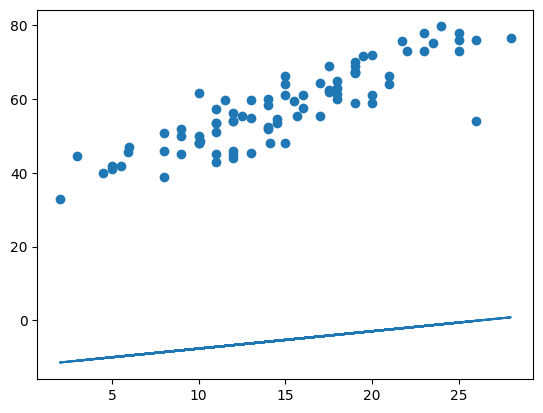

Slope = 0.4710227632555459
Intercept = -12.341115842994016
R value = 0.8774468245770644
p-value = 3.272539651157471e-28
Standard Error = 0.028263643723796136


In [ ]:
slope_sample1, intercept_sample1, r_sample1, p_sample1, std_err_sample1 = stats.linregress(sample_air_temp, sample_water_temp)
print(r_sample1)

def func(x):
  return slope_sample1 * x + intercept_sample1

model = list(map(func, sample_water_temp))

plt.scatter(sample_water_temp, sample_air_temp)
plt.plot(sample_water_temp, model)
plt.show()

print("Slope =", slope_sample1)
print("Intercept =", intercept_sample1)
print("R value =", r_sample1)
print("p-value =", p_sample1)
print("Standard Error =", std_err_sample1)

In [ ]:
X = sample_air_temp
X = sm.add_constant(X)

y = sample_water_temp

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Water Temp (?C)   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     277.7
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           3.27e-28
Time:                        06:13:39   Log-Likelihood:                -207.86
No. Observations:                  85   AIC:                             419.7
Df Residuals:                      83   BIC:                             424.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -12.3411      1.657     -7.449

## Question 3: Based on the results of the regression analysis, make a conclusion about the appropriateness of using ratio and regression estimators. (TEXT ANSWER ONLY)

## Question 4: Estimate your parameter of interest by Ratio estimator. Estimate its variance and give a confidence interval of α level chosen in Report 2.

In [ ]:
# Ratio estimator: mu_hat_r = r * mu_x
# mu_x = T_x / N

print((np.mean(sample_water_temp))/(np.mean(sample_air_temp))) #FRANK CHANGED
ratio_estimator = ((np.mean(sample_water_temp))/(np.mean(sample_air_temp))) #FRANK CHANGED
T_x = sum(df["Air Temp (?F)"])
mu_x = T_x / N

print("mu_x =", mu_x)

mu_hat_r = ratio_estimator * mu_x #Trust in the r_sample1 value being correctly calculated from the sample

print("Ratio estimator =", round(mu_hat_r, 3))

0.25680140827237496
mu_x = 56.72911284046692
Ratio estimator = 14.568


In [ ]:
# Estimation of Variance of Ratio Esitmator: var_hat_mu_hat_r = ((N-n)/N) * (sr_squared/n)
#z = sample_air_temp - r_sample1 * sample_water_temp
z = sample_water_temp - ratio_estimator * sample_air_temp #Frank changed
sr_squared = np.var(z)

var_hat_mu_hat_r = ((N-n)/N)*(sr_squared/n)

print("Estimation of Variance of Ratio Esitmator =", round(var_hat_mu_hat_r, 3))

Estimation of Variance of Ratio Esitmator = 0.129


In [ ]:
# Confidence Inteval = (mu_hat_r - t_value(sqrt(var_hat_mu_hat_r), mu_hat_r + t_value(sqrt(var_hat_mu_hat_r))
alpha = 0.05

t_critical_value = t.ppf(1 - alpha / 2, df= n - 1)

lower_bound = mu_hat_r - t_critical_value * (math.sqrt(var_hat_mu_hat_r))

upper_bound = mu_hat_r + t_critical_value * (math.sqrt(var_hat_mu_hat_r))

print("Confidence Inteval (for alpha = 0.05) =", (round(lower_bound, 3), round(upper_bound, 3)))

Confidence Inteval (for alpha = 0.05) = (13.853, 15.284)


## Question 5: Estimate your parameter of interest by Regression estimator. Estimate its variance and give a confidence interval of α level chosen in Report 2

In [ ]:
# Regression estimator: mu_hat_l = a + (b * mu_x)
# mu_x = T_x / N
# numerator = np.sum((sample_water_temp - x_bar) * (sample_air_temp - y_bar))
# denominator = np.sum((sample_water_temp - x_bar) ** 2)
# b = numerator / denominator
# a = y_bar - (b * x_bar)

T_x = sum(df["Air Temp (?F)"])
mu_x = T_x / N

x_bar = np.mean(sample_air_temp)
y_bar = np.mean(sample_water_temp)

# ASSUME LENGTH X = LENGTH Y
b = sum((sample_air_temp - x_bar) * (sample_water_temp - y_bar))
b /= sum((sample_air_temp - x_bar) ** 2)
a = y_bar - (b * x_bar)

mu_hat_l = a + (b * mu_x)

print("Regression estimator =", round(mu_hat_l, 3))

Regression estimator = 14.38


In [ ]:
# Estimation of Variance of Regression Esitmator: var_hat_mu_hat_l = ((N - n) / (N * n * (n - 2))) * np.sum((y - a - b * x) ** 2)

var_hat_mu_hat_l = ((N - n) / (N * n * (n - 2))) * np.sum((sample_water_temp - a - b * sample_air_temp) ** 2)

print("Estimation of Variance of Regression Esitmator =", round(var_hat_mu_hat_l, 3))

Estimation of Variance of Regression Esitmator = 0.078


In [ ]:
# Confidence Inteval = (mu_hat_r - t_value(sqrt(var_hat_mu_hat_l), mu_hat_r + t_value(sqrt(var_hat_mu_hat_l))
alpha = 0.05

t_critical_value = t.ppf(1 - alpha / 2, df= n - 2)

lower_bound = mu_hat_l - t_critical_value * (math.sqrt(var_hat_mu_hat_l))

upper_bound = mu_hat_l + t_critical_value * (math.sqrt(var_hat_mu_hat_l))

print("Confidence Inteval (for alpha = 0.05) =", (round(lower_bound, 3), round(upper_bound, 3)))

Confidence Inteval (for alpha = 0.05) = (13.823, 14.936)


## Question 6: Choose the best estimator of your parameter based on estimated variance. (TEXT ANSWER ONLY)

## Question 7: Calculate the true regression coefficients. Namely, do regression y ∼ x using whole data set (population). Is your conclusion in the part 3 changed? How does it change?

In [ ]:
whole_pop = pd.DataFrame({
    "WaterTemp": df["Water Temp (?C)"].to_numpy(),
    "AirTemp": df["Air Temp (?F)"].to_numpy()
})
res_whole_pop = smf.ols("WaterTemp ~ AirTemp", data = whole_pop).fit()
res_whole_pop.summary()

print("Coefficients:\n", res_whole_pop.params)
print("\nP-values:\n", res_whole_pop.pvalues)

#water_temp = df["Water Temp (?C)"]
#air_temp = df["Air Temp (?F)"]
#
#slope_complete1, intercept_complete1, r_complete1, p_complete1, std_err_complete1 = stats.linregress(water_temp, air_temp)
#
#def func(x):
#  return slope_complete1 * x + intercept_complete1
#
#model = list(map(func, water_temp))
#
#plt.scatter(water_temp, air_temp)
#plt.plot(water_temp, model)
#plt.show()
#
#print("Slope =", slope_complete1)
#print("Intercept =", intercept_complete1)
#print("R value =", r_complete1)
#print("p-value =", p_complete1)
#print("Standard Error =", std_err_complete1)

Coefficients:
 Intercept   -11.374678
AirTemp       0.449755
dtype: float64

P-values:
 Intercept     8.088877e-69
AirTemp      1.070710e-188
dtype: float64


## Question 8: Repeat steps 1-7 with another auxiliary variable.

## Question 8a: Choose an auxiliary variable x that should be related to your variable of interest y. Take a SRS of size n (the same size as in Report 2).

In [ ]:
# Auxilary Variable chosen: Dissolved Oxygen (standard units)

np.random.seed(42)

population = np.arange(0, N)

sample = np.random.choice(population, size=n, replace=False)

# Performing random sampling (without replacement) for Water Temp
sample_water_temp = df["Water Temp (?C)"].iloc[sample]


# Performing random sampling (without replacement) for Dissolved Oxygen (mg/L)
sample_dissolved_oxygen = df["Dissolved Oxygen (mg/L)"].iloc[sample]

print(sample_water_temp)
print(sample_dissolved_oxygen)

1044    11.0
2265    25.0
1928    18.0
226     11.5
2272    25.0
        ... 
261      8.0
480     12.0
2333    12.0
10      17.5
102     11.0
Name: Water Temp (?C), Length: 85, dtype: float64
1044     7.20
2265     6.90
1928     6.80
226      9.90
2272     4.20
        ...  
261     11.80
480      9.75
2333    10.00
10       8.80
102      9.95
Name: Dissolved Oxygen (mg/L), Length: 85, dtype: float64


## Question 8b: Perform a diagnostic analysis to determine if x and y have a linear relationship based on the sample data. Do regression analysis y ∼ x.

In [ ]:
#This is franks correct code
data_thing = pd.DataFrame({
    "WaterTemp": sample_water_temp,
    "DissolvedOxygen": sample_dissolved_oxygen
})
res = smf.ols("WaterTemp ~ DissolvedOxygen", data = data_thing).fit()
res.summary()
print("Coefficients:\n", res.params)
print("\nP-values:\n", res.pvalues)


Coefficients:
 Intercept          24.172451
DissolvedOxygen    -1.147271
dtype: float64

P-values:
 Intercept          2.423520e-23
DissolvedOxygen    2.048075e-07
dtype: float64


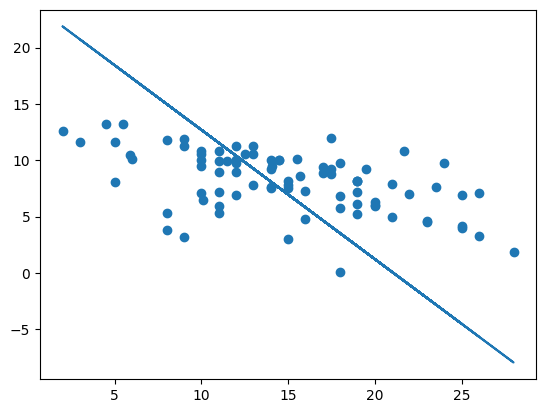

Slope = -1.1472709817727709
Intercept = 24.17245054429617
R value = -0.5281645375243594
p-value = 2.04807465031122e-07
Standard Error = 0.20245945932932727


In [ ]:
slope_sample2, intercept_sample2, r_sample2, p_sample2, std_err_sample2 = stats.linregress(sample_dissolved_oxygen, sample_water_temp)

def func(x):
  return slope_sample2 * x + intercept_sample2

model = list(map(func, sample_water_temp))

plt.scatter(sample_water_temp, sample_dissolved_oxygen)
plt.plot(sample_water_temp, model)
plt.show()

print("Slope =", slope_sample2)
print("Intercept =", intercept_sample2)
print("R value =", r_sample2)
print("p-value =", p_sample2)
print("Standard Error =", std_err_sample2)

In [ ]:
X = sample_dissolved_oxygen
X = sm.add_constant(X)

y = sample_water_temp

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Water Temp (?C)   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     32.11
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           2.05e-07
Time:                        06:13:39   Log-Likelihood:                -256.41
No. Observations:                  85   AIC:                             516.8
Df Residuals:                      83   BIC:                             521.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

## Question 8c: Based on the results of the regression analysis, make a conclusion about the appropriateness of using ratio and regression estimators. (TEXT ANSWER ONLY)

## Question 8d: Estimate your parameter of interest by Ratio estimator. Estimate its variance and give a confidence interval of α level chosen in Report 2

In [ ]:
# Ratio estimator: mu_hat_r = r * mu_x
# mu_x = T_x / N

print((np.mean(sample_water_temp))/(np.mean(sample_dissolved_oxygen))) #FRANK CHANGED
ratio_estimator = ((np.mean(sample_water_temp))/(np.mean(sample_dissolved_oxygen))) #FRANK CHANGED
T_x = sum(df["Dissolved Oxygen (mg/L)"])
mu_x = T_x / N

print("mu_x =", mu_x)

mu_hat_r = ratio_estimator * mu_x #Trust in the r_sample1 value being correctly calculated from the sample

print("Ratio estimator =", round(mu_hat_r, 3))

1.8097952017040142
mu_x = 8.145155642023346
Ratio estimator = 14.741


In [ ]:
# Estimation of Variance of Ratio Esitmator: var_hat_mu_hat_r = ((N-n)/N) * (sr_squared/n)

z = sample_water_temp - ratio_estimator * sample_dissolved_oxygen

sr_squared = np.var(z)

var_hat_mu_hat_r2 = ((N-n)/N)*(sr_squared/n)

print("Estimation of Variance of Ratio Esitmator =", round(var_hat_mu_hat_r2, 3))

Estimation of Variance of Ratio Esitmator = 0.856


In [ ]:
# Confidence Inteval = (mu_hat_r - t_value(sqrt(var_hat_mu_hat_r), mu_hat_r + t_value(sqrt(var_hat_mu_hat_r))
alpha = 0.05


t_critical_value = t.ppf(1 - alpha / 2, df= n - 1)


lower_bound = mu_hat_r - t_critical_value * (math.sqrt(var_hat_mu_hat_r2))


upper_bound = mu_hat_r + t_critical_value * (math.sqrt(var_hat_mu_hat_r2))


print("Confidence Inteval (for alpha = 0.05) =", (round(lower_bound, 3), round(upper_bound, 3)))

Confidence Inteval (for alpha = 0.05) = (12.901, 16.581)


## Question 8e: Estimate your parameter of interest by Regression estimator. Estimate its variance and give a confidence interval of α level chosen in Report 2.

In [ ]:
# Regression estimator: mu_hat_l = a + (b * mu_x)
# mu_x = T_x / N
# numerator = np.sum((sample_water_temp - x_bar) * (sample_air_temp - y_bar))
# denominator = np.sum((sample_water_temp - x_bar) ** 2)
# b = numerator / denominator
# a = y_bar - (b * x_bar)


T_x = sum(df["Dissolved Oxygen (mg/L)"])
mu_x = T_x / N

x_bar = np.mean(sample_dissolved_oxygen)
y_bar = np.mean(sample_water_temp)

# ASSUME LENGTH X = LENGTH Y
b = sum((sample_dissolved_oxygen - x_bar) * (sample_water_temp - y_bar))
b /= sum((sample_dissolved_oxygen - x_bar) ** 2)
a = y_bar - (b * x_bar)

mu_hat_l = a + (b * mu_x)

print("Regression estimator =", round(mu_hat_l, 3))

Regression estimator = 14.828


In [ ]:
# Estimation of Variance of Regression Esitmator: var_hat_mu_hat_l = ((N - n) / (N * n * (n - 2))) * np.sum((y - a - b * x) ** 2)

var_hat_mu_hat_l = ((N - n) / (N * n * (n - 2))) * np.sum((sample_water_temp - a - b * sample_dissolved_oxygen) ** 2)

print("Estimation of Variance of Regression Esitmator =", round(var_hat_mu_hat_l, 3))

Estimation of Variance of Regression Esitmator = 0.246


In [ ]:
# Confidence Inteval = (mu_hat_r - t_value(sqrt(var_hat_mu_hat_l), mu_hat_r + t_value(sqrt(var_hat_mu_hat_l))
alpha = 0.05

t_critical_value = t.ppf(1 - alpha / 2, df= n - 2)

lower_bound = mu_hat_l - t_critical_value * (math.sqrt(var_hat_mu_hat_l))

upper_bound = mu_hat_l + t_critical_value * (math.sqrt(var_hat_mu_hat_l))

print("Confidence Inteval (for alpha = 0.05) =", (round(lower_bound, 3), round(upper_bound, 3)))

Confidence Inteval (for alpha = 0.05) = (13.842, 15.813)


## Question 8f: Choose the best estimator of your parameter based on estimated variance. (TEXT ANSWER ONLY)

## Question 8g: Calculate the true regression coefficients. Namely, do regression y ∼ x using whole data set (population). Is your conclusion in the part 3 changed? How does it change?

In [ ]:
#New correct Code
whole_pops = pd.DataFrame({
    "WaterTemp": df["Water Temp (?C)"].to_numpy(),
    "DissolvedOxygen": df["Dissolved Oxygen (mg/L)"].to_numpy()
})
res_whole_pops = smf.ols("WaterTemp ~ DissolvedOxygen", data = whole_pops).fit()
res_whole_pops.summary()

print("Coefficients:\n", res_whole_pop.params)
print("\nP-values:\n", res_whole_pop.pvalues)

Coefficients:
 Intercept   -11.374678
AirTemp       0.449755
dtype: float64

P-values:
 Intercept     8.088877e-69
AirTemp      1.070710e-188
dtype: float64


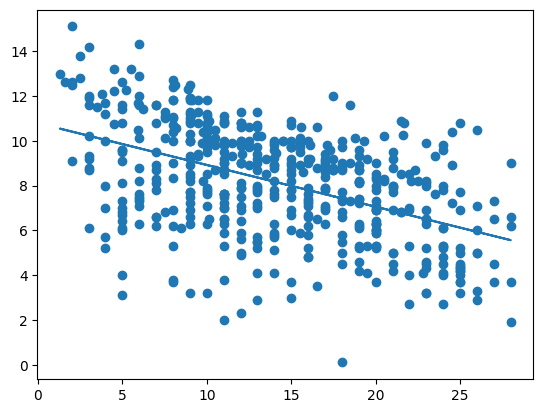

Slope = -0.18652566716971444
Intercept = 10.782537853202344
R value = -0.48479018084345243
p-value = 1.183125866799803e-31
Standard Error = 0.014872172560039325


In [ ]:
water_temp = df["Water Temp (?C)"]
dissolved_oxygen = df["Dissolved Oxygen (mg/L)"]

slope_complete2, intercept_complete2, r_complete2, p_complete2, std_err_complete2 = stats.linregress(water_temp, dissolved_oxygen)

def func(x):
  return slope_complete2 * x + intercept_complete2

model = list(map(func, water_temp))

plt.scatter(water_temp, dissolved_oxygen)
plt.plot(water_temp, model)
plt.show()

print("Slope =", slope_complete2)
print("Intercept =", intercept_complete2)
print("R value =", r_complete2)
print("p-value =", p_complete2)
print("Standard Error =", std_err_complete2)

# Report 5

In [ ]:
# True Parameter
import random
import statistics

mu = 14.227

# Population Size
N = 514

# Total Sample Size
n = 85

## Question 1: Divide your population into strata with unequal sizes (Nh’s) using any variable besides the variable of interest. It can be a categorical variable as well


In [ ]:
# Random sampling
np.random.seed(419)

# Get the data
full_list = list(range(0, N))
full_df = df['Air Temp (?F)'].iloc[full_list].copy()


ful = df["Water Temp (?C)"].iloc[full_list].copy()

maximum = -100
minimum = 90
for i, value in enumerate(ful):
  if value < minimum:
    minimum = value
  if value > maximum:
    maximum = value
print("max: ", maximum)
print("min: ", minimum)
#print(ful)


max:  28.0
min:  1.3


In [ ]:
# Stratify the sample using Air Temperature

list_1 = list()
list_2 = list()
list_3 = list()
list_4 = list()
list_5 = list()

for i, value in enumerate(full_df):
    original_index = df.index[full_list[i]]  # Get the original index
    #print(f"Original Index: {original_index}, Value: {value}")
    if value < 40 :
    #Append list_1
      list_1.append(original_index)
    elif value >= 40 and value < 50 :
    #Append list_2
      list_2.append(original_index)
    elif value >= 50 and value < 60 :
    #Append list_3
      list_3.append(original_index)
    elif value >= 60 and value < 70 :
    #Append list_4
      list_4.append(original_index)
    else:
    #Append list_5
      list_5.append(original_index)

#We will acess stuff in the lists this way
#value = df.loc[original_index, 'Water Temp (?C)']
list_of_lists_1 = list()

to_add = list()
for x in list_1:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_1.append(to_add)
to_add = list()
for x in list_2:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_1.append(to_add)
to_add = list()
for x in list_3:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_1.append(to_add)
to_add = list()
for x in list_4:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_1.append(to_add)
to_add = list()
for x in list_5:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_1.append(to_add)
print("First way of stratifying the population: ")
print("I used 5 groups. The Nh's are below")
counter = 1
cou = 0
for g in list_of_lists_1:
  print("N_", counter, " : ", len(g))
  counter  = counter + 1

#Population Stratification 2

list_1_2 = list()
list_2_2 = list()
list_3_2 = list()
list_4_2 = list()
for i, value in enumerate(full_df):
    original_index = df.index[full_list[i]]  # Get the original index
    #print(f"Original Index: {original_index}, Value: {value}")
    if value < 40 :
      list_1_2.append(original_index)
    elif value >= 40 and value < 55 :
      list_2_2.append(original_index)
    elif value >= 55 and value < 70 :
      list_3_2.append(original_index)
    else:
      list_4_2.append(original_index)

list_of_lists_2 = list()

to_add = list()
for x in list_1_2:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_2.append(to_add)
to_add = list()
for x in list_2_2:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_2.append(to_add)
to_add = list()
for x in list_3_2:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_2.append(to_add)
to_add = list()
for x in list_4_2:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_2.append(to_add)

print("Second way of stratifying the population: ")
print("I used 4 groups. The Nh's are below")
counter = 1
for g in list_of_lists_2:
  print("N_", counter, " : ", len(g))
  counter  = counter + 1
#Population Stratification 3

list_1_3 = list()
list_2_3 = list()
list_3_3 = list()
for i, value in enumerate(full_df):
    original_index = df.index[full_list[i]]  # Get the original index
    #print(f"Original Index: {original_index}, Value: {value}")
    if value < 40 :
      list_1_3.append(original_index)
    elif value >= 45 and value < 65 :
      list_2_3.append(original_index)
    else:
      list_3_3.append(original_index)

list_of_lists_3 = list()

to_add = list()
for x in list_1_3:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_3.append(to_add)
to_add = list()
for x in list_2_3:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_3.append(to_add)
to_add = list()
for x in list_3_3:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_3.append(to_add)


print("Third way of stratifying the population: ")
print("I used 3 groups. The Nh's are below")
counter = 1
for g in list_of_lists_3:
  print("N_",counter, " : ", len(g))
  counter  = counter + 1

First way of stratifying the population: 
I used 5 groups. The Nh's are below
N_ 1  :  46
N_ 2  :  120
N_ 3  :  143
N_ 4  :  109
N_ 5  :  96
Second way of stratifying the population: 
I used 4 groups. The Nh's are below
N_ 1  :  46
N_ 2  :  181
N_ 3  :  191
N_ 4  :  96
Third way of stratifying the population: 
I used 3 groups. The Nh's are below
N_ 1  :  46
N_ 2  :  277
N_ 3  :  191


## Question 2: Calculate ∆ for at least three different ways of stratifying your population

In [ ]:
#Calculate ∆ for the first method of stratification

#Obtaining full population

fulll = list()
to__add = list()
for i, value in enumerate(full_df):
  original_index = df.index[full_list[i]]  # Get the original index
  to__add.append(value)
fulll.append(to__add)

full_var = 0
for lis in fulll:
  delta_toadd = 0
  for r in lis:
    delta_toadd = delta_toadd + ((r - np.mean(lis))**2)
  full_var = full_var + (delta_toadd)

delta_1 = full_var
for lis in list_of_lists_1:
  delta_toadd = 0
  for r in lis:
    delta_toadd = delta_toadd + ((r - np.mean(lis))**2)
  delta_1 = delta_1 - (delta_toadd)

delta_2 = full_var
for lis in list_of_lists_2:
  delta_toadd = 0
  for r in lis:
    delta_toadd = delta_toadd + ((r - np.mean(lis))**2)
  delta_2 = delta_2 - (delta_toadd)

delta_3 = full_var
for lis in list_of_lists_3:
  delta_toadd = 0
  for r in lis:
    delta_toadd = delta_toadd + ((r - np.mean(lis))**2)
  delta_3 = delta_3 - (delta_toadd)

print("Three deltas: ", delta_1, delta_2, delta_3)

Three deltas:  79405.14907503518 78438.49403053077 70536.31736464282


## Question 3: Take stratified random sample with size n (chosen in Report 2) with equal allocation. (nh = nL)

In [ ]:
# Parameters based on Report 2
N = 514
n = 85
alpha = 0.05

#Stratified random sampling with equal allocation
# Since we are using method one for stratification L  = 5
L =  5
n_all = n // L
list_of_nhs = [n_all, n_all, n_all, n_all, n_all]
print("Stratified random sampling with equal allocation")
print("Equal allocation: n_1 = ", n_all, "n_2 = ", n_all, "n_3 = ", n_all, "n_4 = ", n_all, "n_5 = ", n_all)

#Generate the indices of the random sample
random_indices = list()
for g in range(0, 5):
  gg = random.sample(list(range(0, len(list_of_lists_1[g]))), list_of_nhs[g])
  random_indices.append(gg)
y_bar_h = list()
for g in range(0, 5):
  y_bar = 0
  for x in random_indices[g]:
    y_bar = y_bar + list_of_lists_1[g][x]
  y_bar = y_bar / list_of_nhs[g]
  y_bar_h.append(y_bar)
s_squared_h = list()
for g in range(0, 5):
  to_addd = 0
  for x in random_indices[g]:
    to_addd = to_addd + ((list_of_lists_1[g][x] - y_bar_h[g]) ** 2)
  to_addd = to_addd / (list_of_nhs[g] - 1)
  s_squared_h.append(to_addd)
#Estimate the parameter of interest
tau_hat_st = 0
for g in range(0, 5):
  tau_hat_st = tau_hat_st + (len(list_of_lists_1[g]))*(y_bar_h[g])
mu_hat_st = tau_hat_st / N
display(Math(r'{\hat{\mu_{st}}} = ' + str(round(mu_hat_st, 3))))
#Estimated variance of the parameter of interest
var_hat_tau_hat_st = 0
for g in range(0, 5):
  cap = (len(list_of_lists_1[g]))*(len(list_of_lists_1[g]) - list_of_nhs[g])*((s_squared_h[g])/(list_of_nhs[g]))
  var_hat_tau_hat_st = var_hat_tau_hat_st + cap
var_hat_mu_hat_st = var_hat_tau_hat_st / (N ** 2)
display(Math(r'{\hat{var}}({\hat{\mu_{st}}}) = ' + str(round(var_hat_mu_hat_st, 3))))

#We will use Satterthwaite formula for adjusted degrees of freedom
number_1 = 0
number_2 = 0
for g in range(0, 5):
  number_1 = number_1 + (len(list_of_lists_1[g]))*(len(list_of_lists_1[g]) - list_of_nhs[g])*((s_squared_h[g])/(list_of_nhs[g]))
  number_2 = number_2 + ((((len(list_of_lists_1[g]))*(len(list_of_lists_1[g]) - list_of_nhs[g])*((s_squared_h[g])/(list_of_nhs[g]))) ** 2) / (list_of_nhs[g] - 1))
degrees_of_freedom = (number_1 ** 2) / number_2
print("Degrees of Freedom: ", degrees_of_freedom)
#The alpha level chosen in report 2 was 0.95
#A 95% CI for my estimator is below

# First get the t-distribution crictal value
alpha = 0.05
t_critical_95 = t.ppf(1 - alpha / 2, df = degrees_of_freedom)

# Calculating the lower and upper bounds of the confidence interval
lower_95_CI = round(mu_hat_st - (t_critical_95 * np.sqrt(var_hat_mu_hat_st)), 3)
upper_95_CI = round(mu_hat_st + (t_critical_95 * np.sqrt(var_hat_mu_hat_st)), 3)

print("95% CI:", {lower_95_CI}, {upper_95_CI})

Stratified random sampling with equal allocation
Equal allocation: n_1 =  17 n_2 =  17 n_3 =  17 n_4 =  17 n_5 =  17


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Degrees of Freedom:  46.55628425778407
95% CI: {13.368} {14.751}


## Question 4: Take stratified random sample with size n (chosen in Report 2) with proportional allocation. (nh = nL)

In [ ]:
#Stratified Random Sample with Proportional allocation
print("Stratified Random Sample with Proportional allocation")
print("The nh's are below")
list_of_nhs = list()
counter = 1
for g in list_of_lists_1:
  top = int(round((n * len(g)) / N))
  list_of_nhs.append(top)
  print("n_",counter, " : ", top, "rounded from: ", ((n * len(g)) / N))
  counter  = counter + 1
print("Since n_1 was rounded the most and the sum of the n_h's is 86 and is not equal to n. I manually adjust n_1 to be 7")
list_of_nhs[0] = 7

counter = 1
for g in list_of_nhs:
  print("n_",counter, " : ", g)
  counter  = counter + 1
#Generate the indices of the random sample
random_indices = list()
for g in range(0, 5):
  gg = random.sample(list(range(0, len(list_of_lists_1[g]))), list_of_nhs[g])
  random_indices.append(gg)
y_bar_h = list()
for g in range(0, 5):
  y_bar = 0
  for x in random_indices[g]:
    y_bar = y_bar + list_of_lists_1[g][x]
  y_bar = y_bar / list_of_nhs[g]
  y_bar_h.append(y_bar)
s_squared_h = list()
for g in range(0, 5):
  to_addd = 0
  for x in random_indices[g]:
    to_addd = to_addd + ((list_of_lists_1[g][x] - y_bar_h[g]) ** 2)
  to_addd = to_addd / (list_of_nhs[g] - 1)
  s_squared_h.append(to_addd)
#Estimate the parameter of interest
tau_hat_st = 0
for g in range(0, 5):
  tau_hat_st = tau_hat_st + (len(list_of_lists_1[g]))*(y_bar_h[g])
mu_hat_st = tau_hat_st / N
display(Math(r'{\hat{\mu_{st}}} = ' + str(round(mu_hat_st, 3))))
#Estimated variance of the parameter of interest
var_hat_tau_hat_st = 0
for g in range(0, 5):
  cap = (len(list_of_lists_1[g]))*(len(list_of_lists_1[g]) - list_of_nhs[g])*((s_squared_h[g])/(list_of_nhs[g]))
  var_hat_tau_hat_st = var_hat_tau_hat_st + cap
var_hat_mu_hat_st = var_hat_tau_hat_st / (N ** 2)
display(Math(r'{\hat{var}}({\hat{\mu_{st}}}) = ' + str(round(var_hat_mu_hat_st, 3))))

#We will use Satterthwaite formula for adjusted degrees of freedom
number_1 = 0
number_2 = 0
for g in range(0, 5):
  number_1 = number_1 + (len(list_of_lists_1[g]))*(len(list_of_lists_1[g]) - list_of_nhs[g])*((s_squared_h[g])/(list_of_nhs[g]))
  number_2 = number_2 + ((((len(list_of_lists_1[g]))*(len(list_of_lists_1[g]) - list_of_nhs[g])*((s_squared_h[g])/(list_of_nhs[g]))) ** 2) / (list_of_nhs[g] - 1))
degrees_of_freedom = (number_1 ** 2) / number_2
print("Degrees of Freedom: ", degrees_of_freedom)
#The alpha level chosen in report 2 was 0.95
#A 95% CI for my estimator is below

# First get the t-distribution crictal value
alpha = 0.05
t_critical_95 = t.ppf(1 - alpha / 2, df = degrees_of_freedom)

# Calculating the lower and upper bounds of the confidence interval
lower_95_CI = round(mu_hat_st - (t_critical_95 * np.sqrt(var_hat_mu_hat_st)), 3)
upper_95_CI = round(mu_hat_st + (t_critical_95 * np.sqrt(var_hat_mu_hat_st)), 3)

print("95% CI:", {lower_95_CI}, {upper_95_CI})

Stratified Random Sample with Proportional allocation
The nh's are below
n_ 1  :  8 rounded from:  7.607003891050583
n_ 2  :  20 rounded from:  19.844357976653697
n_ 3  :  24 rounded from:  23.647859922178988
n_ 4  :  18 rounded from:  18.025291828793776
n_ 5  :  16 rounded from:  15.875486381322958
Since n_1 was rounded the most and the sum of the n_h's is 86 and is not equal to n. I manually adjust n_1 to be 7
n_ 1  :  7
n_ 2  :  20
n_ 3  :  24
n_ 4  :  18
n_ 5  :  16


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Degrees of Freedom:  69.64378403820413
95% CI: {13.147} {14.191}


## Question 5: Take stratified random sample with size n (chosen in Report 2) with Optimum allocation. (nh = nL)

In [ ]:
#Stratified Random Sample with Optimum allocation
sigma_squared_h = list()
for lis in list_of_lists_1:
  delta_toadd = 0
  for r in lis:
    delta_toadd = delta_toadd + ((r - np.mean(lis))**2)
  delta_toadd = delta_toadd * (1/(len(lis) - 1))
  sigma_squared_h.append(delta_toadd)

important_number = 0
for g in range(0, 5):
  important_number = important_number + (len(list_of_lists_1[g]))*(math.sqrt(sigma_squared_h[g]))
print("Stratified Random Sample with Optimum allocation")
print("The nh's are below")
list_of_nhs = list()

counter = 1
for g in range(0, 5):
  top = int(round((n*(len(list_of_lists_1[g]))*(math.sqrt(sigma_squared_h[g]))) / (important_number)))
  list_of_nhs.append(top)
  print("n_",counter, " : ", top)
  counter  = counter + 1

#Generate the indices of the random sample
random_indices = list()
for g in range(0, 5):
  gg = random.sample(list(range(0, len(list_of_lists_1[g]))), list_of_nhs[g])
  random_indices.append(gg)
y_bar_h = list()
for g in range(0, 5):
  y_bar = 0
  for x in random_indices[g]:
    y_bar = y_bar + list_of_lists_1[g][x]
  y_bar = y_bar / list_of_nhs[g]
  y_bar_h.append(y_bar)
s_squared_h = list()
for g in range(0, 5):
  to_addd = 0
  for x in random_indices[g]:
    to_addd = to_addd + ((list_of_lists_1[g][x] - y_bar_h[g]) ** 2)
  to_addd = to_addd / (list_of_nhs[g] - 1)
  s_squared_h.append(to_addd)
#Estimate the parameter of interest
tau_hat_st = 0
for g in range(0, 5):
  tau_hat_st = tau_hat_st + (len(list_of_lists_1[g]))*(y_bar_h[g])
mu_hat_st = tau_hat_st / N
display(Math(r'{\hat{\mu_{st}}} = ' + str(round(mu_hat_st, 3))))
#Estimated variance of the parameter of interest
var_hat_tau_hat_st = 0
for g in range(0, 5):
  cap = (len(list_of_lists_1[g]))*(len(list_of_lists_1[g]) - list_of_nhs[g])*((s_squared_h[g])/(list_of_nhs[g]))
  var_hat_tau_hat_st = var_hat_tau_hat_st + cap
var_hat_mu_hat_st = var_hat_tau_hat_st / (N ** 2)
display(Math(r'{\hat{var}}({\hat{\mu_{st}}}) = ' + str(round(var_hat_mu_hat_st, 3))))

#We will use Satterthwaite formula for adjusted degrees of freedom
number_1 = 0
number_2 = 0
for g in range(0, 5):
  number_1 = number_1 + (len(list_of_lists_1[g]))*(len(list_of_lists_1[g]) - list_of_nhs[g])*((s_squared_h[g])/(list_of_nhs[g]))
  number_2 = number_2 + ((((len(list_of_lists_1[g]))*(len(list_of_lists_1[g]) - list_of_nhs[g])*((s_squared_h[g])/(list_of_nhs[g]))) ** 2) / (list_of_nhs[g] - 1))
degrees_of_freedom = (number_1 ** 2) / number_2
print("Degrees of Freedom: ", degrees_of_freedom)
#The alpha level chosen in report 2 was 0.95
#A 95% CI for my estimator is below

# First get the t-distribution crictal value
alpha = 0.05
t_critical_95 = t.ppf(1 - alpha / 2, df = degrees_of_freedom)

# Calculating the lower and upper bounds of the confidence interval
lower_95_CI = round(mu_hat_st - (t_critical_95 * np.sqrt(var_hat_mu_hat_st)), 3)
upper_95_CI = round(mu_hat_st + (t_critical_95 * np.sqrt(var_hat_mu_hat_st)), 3)

print("95% CI:", {lower_95_CI}, {upper_95_CI})

Stratified Random Sample with Optimum allocation
The nh's are below
n_ 1  :  9
n_ 2  :  19
n_ 3  :  24
n_ 4  :  20
n_ 5  :  13


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Degrees of Freedom:  75.37323664909475
95% CI: {13.33} {14.395}


# Report 6

# Question 1: Perform a systematic sample with (approximately) the same total sample size as you used in previous Reports.

In [ ]:
np.random.seed(42)
# Parameters
M = 514 #Total number of units in the population
needed_sample_size = 85 #Total sample size we need
n = 5 # Sample size of primary units
N = 30 # Number of Primary Units in the population

import random
import statistics
# Generate initial sample of 5 random indices between 0 and 29 inclusive
random_indices1 = random.sample(list(range(0, N)), n)

# Generate a larger sample by adding 30, 17 times to each initial sample index
larger_sample1 = []
j = 0
while j <= 510:
    for index in random_indices1:
        if j + index >= 514 :
          break;
        else:
          larger_sample1.extend([j + index])
    j += 30

print("Sampled Indices:", larger_sample1)



Sampled Indices: [6, 3, 1, 7, 19, 36, 33, 31, 37, 49, 66, 63, 61, 67, 79, 96, 93, 91, 97, 109, 126, 123, 121, 127, 139, 156, 153, 151, 157, 169, 186, 183, 181, 187, 199, 216, 213, 211, 217, 229, 246, 243, 241, 247, 259, 276, 273, 271, 277, 289, 306, 303, 301, 307, 319, 336, 333, 331, 337, 349, 366, 363, 361, 367, 379, 396, 393, 391, 397, 409, 426, 423, 421, 427, 439, 456, 453, 451, 457, 469, 486, 483, 481, 487, 499]


# 3. Estimate your parameter of interest by an unbiased estimator. Estimate its variance and give a confidence interval of α level chosen in report 2

In [ ]:
np.random.seed(42)
#The lists below contain the primary units I declare but don't initialize them.
list_1 = []
list_2 = []
list_3 = []
list_4 = []
list_5 = []
#Instantiate the primary units
j = 0
while j <= 510:
    for k in range(5):
        if j + random_indices1[k] >= 514 :
          break;
        else:
          if k == 0:
            list_1.extend([j + random_indices1[k]])
          elif k == 1:
            list_2.extend([j + random_indices1[k]])
          elif k == 2:
            list_3.extend([j + random_indices1[k]])
          elif k == 3:
            list_4.extend([j + random_indices1[k]])
          else:
            list_5.extend([j + random_indices1[k]])
    j += 30

y_1_ = df["Water Temp (?C)"].iloc[list_1]
y_2_ = df["Water Temp (?C)"].iloc[list_2]
y_3_ = df["Water Temp (?C)"].iloc[list_3]
y_4_ = df["Water Temp (?C)"].iloc[list_4]
y_5_ = df["Water Temp (?C)"].iloc[list_5]

primary_unit_totals1 = [y_1_.sum(), y_2_.sum(), y_3_.sum(), y_4_.sum(), y_5_.sum()]
#Estimated parameter of interest is below
mu_hat_1 = ((N/n)*((y_1_.sum())+(y_2_.sum())+(y_3_.sum())+(y_4_.sum())+(y_5_.sum())))/M

display(Math(r'{\hat{\mu}} = ' + str(round(mu_hat_1, 3))))

#Estimated Variance of the parameter of Interest
s_u_squared1 = 0
for y_i in primary_unit_totals1:
  s_u_squared1 += (y_i - statistics.mean(primary_unit_totals1)) ** 2
s_u_squared1 = s_u_squared1 / (n - 1)

var_hat_mu_hat1 = (1/(M ** 2))*((N*(N - n)*s_u_squared1)/(n))

display(Math(r'{\hat{var}}({\hat{\mu}}) = ' + str(round(var_hat_mu_hat1, 3))))

#The alpha level chosen in report 2 was 0.95
#A 95% CI for my estimator is [12.944, 15.784]

# First get the t-distribution crictal value
alpha = 0.05
t_critical_95 = t.ppf(1 - alpha / 2, df = len(larger_sample1) - 1)

# Calculating the lower and upper bounds of the confidence interval
lower_95_CI = round(mu_hat_1 - (t_critical_95 * np.sqrt(var_hat_mu_hat1)), 3)
upper_95_CI = round(mu_hat_1 + (t_critical_95 * np.sqrt(var_hat_mu_hat1)), 3)

print("95% CI:", {lower_95_CI}, {upper_95_CI})


<IPython.core.display.Math object>

<IPython.core.display.Math object>

95% CI: {13.783} {15.512}


# 4. Perform another systematic sampling approach, but this time, let’s change the value of N that you used before. (As result, your n will be changed also).

In [ ]:
# New Parameters
M = 514 #Total number of units in the population
needed_sample_size = 85 #Total sample size we need
n = 17 # Sample size of primary units
N = 103 # Number of Primary Units in the population

# 102 of the primary units contain 5 elements and 1 contains 4 elements

In [ ]:
np.random.seed(42)
# Generate initial sample of 5 random indices between 0 and 103
random_indices = random.sample(list(range(0, N)), n)

# Generate a larger sample by adding 30, 17 times to each initial sample index
larger_sample = []
j = 0
while j <= 510:
    for index in random_indices:
        if j + index >= 514 :
          break;
        else:
          larger_sample.extend([j + index])
    j += 103

print("Sampled Indices:", larger_sample)

Sampled Indices: [17, 6, 59, 14, 33, 41, 25, 80, 83, 94, 85, 34, 49, 30, 57, 47, 87, 120, 109, 162, 117, 136, 144, 128, 183, 186, 197, 188, 137, 152, 133, 160, 150, 190, 223, 212, 265, 220, 239, 247, 231, 286, 289, 300, 291, 240, 255, 236, 263, 253, 293, 326, 315, 368, 323, 342, 350, 334, 389, 392, 403, 394, 343, 358, 339, 366, 356, 396, 429, 418, 471, 426, 445, 453, 437, 492, 495, 506, 497, 446, 461, 442, 469, 459, 499]


5. Estimate your parameter of interest by an unbiased estimator. Estimate its variance and give a confidence interval of α level chosen in Report 2.

In [ ]:
np.random.seed(42)
#The list of lists below contains the primary units that have not yet been initialized
list_of_lists = []
#for i in range(17):
#  list_of_lists.append([])
#Instantiate the primary units
for f in range(len(random_indices)):
  primary_unit = []
  for g in range(5):
    if g*103 + random_indices[f] >= 514:
      break
    else:
      primary_unit.append(g*103 + random_indices[f])
  list_of_lists.append(primary_unit)

y_i = []
for y in list_of_lists:
  y_toadd = df["Water Temp (?C)"].iloc[y]
  y_i.append(y_toadd)

primary_unit_totals = []
for y in y_i:
  primary_unit_totals.append(y.sum())
#Estimated parameter of interest is below
mu_hat_ = 0
for y in primary_unit_totals:
  mu_hat_ += y
mu_hat_ = ((N/n)*(mu_hat_))/M

display(Math(r'{\hat{\mu}} = ' + str(round(mu_hat_, 3))))

#Estimated Variance of the parameter of Interest
s_u_squared = 0
for y_i in primary_unit_totals:
  s_u_squared += (y_i - statistics.mean(primary_unit_totals)) ** 2
s_u_squared = s_u_squared / (n - 1)

var_hat_mu_hat = (1/(M ** 2))*((N*(N - n)*s_u_squared)/(n))

display(Math(r'{\hat{var}}({\hat{\mu}}) = ' + str(round(var_hat_mu_hat, 3))))

#The alpha level chosen in report 2 was 0.95
#A 95% CI for my estimator is [12.931, 14.367]

# First get the t-distribution crictal value
alpha = 0.05
t_critical_95 = t.ppf(1 - alpha / 2, df = len(larger_sample) - 1)

# Calculating the lower and upper bounds of the confidence interval
lower_95_CI = round(mu_hat_ - (t_critical_95 * np.sqrt(var_hat_mu_hat)), 3)
upper_95_CI = round(mu_hat_ + (t_critical_95 * np.sqrt(var_hat_mu_hat)), 3)

print("95% CI:", {lower_95_CI}, {upper_95_CI})

<IPython.core.display.Math object>

<IPython.core.display.Math object>

95% CI: {13.367} {15.821}


6. Order your population with respect to y (variable of interest). Repeat
steps 1-4 for the ordered data.

In [ ]:
np.random.seed(42)
#Parameters
M = 514 #Total number of units in the population
needed_sample_size = 85 #Total sample size we need
n = 5 # Sample size of primary units
N = 30 # Number of Primary Units in the population

#random_indices1 #Still holds the same indices from before to enable an accurate comparison
#larger_sample1 # Still holds the same sample indices as before

print("All Sample Indices: ", larger_sample1)

#The lists below contain the primary units I declare but don't initialize them.
list_1__ = []
list_2__ = []
list_3__ = []
list_4__ = []
list_5__ = []
#Instantiate the primary units
j = 0
while j <= 510:
    for k in range(5):
        if j + random_indices1[k] >= 514 :
          break;
        else:
          if k == 0:
            list_1__.extend([j + random_indices1[k]])
          elif k == 1:
            list_2__.extend([j + random_indices1[k]])
          elif k == 2:
            list_3__.extend([j + random_indices1[k]])
          elif k == 3:
            list_4__.extend([j + random_indices1[k]])
          else:
            list_5__.extend([j + random_indices1[k]])
    j += 30


list_of_all__ = df["Water Temp (?C)"].iloc[list(range(514))]
list_of_all__ = list_of_all__.sort_values()


list_1__new = list()
list_2__new = list()
list_3__new = list()
list_4__new = list()
list_5__new = list()
for i in list_1__:
  list_1__new.append(list_of_all__.iloc[i])
for i in list_2__:
  list_2__new.append(list_of_all__.iloc[i])
for i in list_3__:
  list_3__new.append(list_of_all__.iloc[i])
for i in list_4__:
  list_4__new.append(list_of_all__.iloc[i])
for i in list_5__:
  list_5__new.append(list_of_all__.iloc[i])

primary_unit_totals1 = [sum(list_1__new), sum(list_2__new), sum(list_3__new), sum(list_4__new), sum(list_5__new)]
#Estimated parameter of interest is below
mu_hat_1 = ((N/n)*((sum(list_1__new))+(sum(list_2__new))+(sum(list_3__new))+(sum(list_4__new))+(sum(list_5__new))))/M

display(Math(r'{\hat{\mu}} = ' + str(round(mu_hat_1, 3))))

#Estimated Variance of the parameter of Interest
s_u_squared1 = 0
for y_i in primary_unit_totals1:
  s_u_squared1 += (y_i - statistics.mean(primary_unit_totals1)) ** 2
s_u_squared1 = s_u_squared1 / (n - 1)

var_hat_mu_hat1 = (1/(M ** 2))*((N*(N - n)*s_u_squared1)/(n))

display(Math(r'{\hat{var}}({\hat{\mu}}) = ' + str(round(var_hat_mu_hat1, 3))))

#The alpha level chosen in report 2 was 0.95
#A 95% CI for my estimator is [13.815, 15.01]

# First get the t-distribution crictal value
alpha = 0.05
t_critical_95 = t.ppf(1 - alpha / 2, df = len(larger_sample1) - 1)

# Calculating the lower and upper bounds of the confidence interval
lower_95_CI = round(mu_hat_1 - (t_critical_95 * np.sqrt(var_hat_mu_hat1)), 3)
upper_95_CI = round(mu_hat_1 + (t_critical_95 * np.sqrt(var_hat_mu_hat1)), 3)

print("95% CI:", {lower_95_CI}, {upper_95_CI})


All Sample Indices:  [6, 3, 1, 7, 19, 36, 33, 31, 37, 49, 66, 63, 61, 67, 79, 96, 93, 91, 97, 109, 126, 123, 121, 127, 139, 156, 153, 151, 157, 169, 186, 183, 181, 187, 199, 216, 213, 211, 217, 229, 246, 243, 241, 247, 259, 276, 273, 271, 277, 289, 306, 303, 301, 307, 319, 336, 333, 331, 337, 349, 366, 363, 361, 367, 379, 396, 393, 391, 397, 409, 426, 423, 421, 427, 439, 456, 453, 451, 457, 469, 486, 483, 481, 487, 499]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

95% CI: {13.285} {13.874}


In [ ]:
np.random.seed(42)
# New Parameters    repeat above step 4 and 5 with new parameters
M = 514 #Total number of units in the population
needed_sample_size = 85 #Total sample size we need
n = 17 # Sample size of primary units
N = 103 # Number of Primary Units in the population

# 102 of the primary units contain 5 elements and 1 contains 4 elements

#random_indices #Still holds the same indices from before to enable an accurate comparison
#larger_sample # Still holds the same sample indices as before

print("All Sample Indices: ", larger_sample)

#The list of lists below contains the primary units that have not yet been initialized
list_of_lists = []
#for i in range(17):
#  list_of_lists.append([])
#Instantiate the primary units
for f in range(len(random_indices)):
  primary_unit = []
  for g in range(5):
    if g*103 + random_indices[f] >= 514:
      break
    else:
      primary_unit.append(g*103 + random_indices[f])
  list_of_lists.append(primary_unit)

y_i = []

#Sort the data
list_of_all__2 = df["Water Temp (?C)"].iloc[list(range(514))]
list_of_all__2 = list_of_all__2.sort_values()

for y in list_of_lists:
  y_toadd = list_of_all__2.iloc[y]
  y_i.append(y_toadd)

primary_unit_totals = []
for y in y_i:
  primary_unit_totals.append(y.sum())
#Estimated parameter of interest is below
mu_hat_ = 0
for y in primary_unit_totals:
  mu_hat_ += y
mu_hat_ = ((N/n)*(mu_hat_))/M

display(Math(r'{\hat{\mu}} = ' + str(round(mu_hat_, 3))))

#Estimated Variance of the parameter of Interest
s_u_squared = 0
for y_i in primary_unit_totals:
  s_u_squared += (y_i - statistics.mean(primary_unit_totals)) ** 2
s_u_squared = s_u_squared / (n - 1)

var_hat_mu_hat = (1/(M ** 2))*((N*(N - n)*s_u_squared)/(n))

display(Math(r'{\hat{var}}({\hat{\mu}}) = ' + str(round(var_hat_mu_hat, 3))))

#The alpha level chosen in report 2 was 0.95
#A 95% CI for my estimator is [13.912, 15.311]

# First get the t-distribution crictal value
alpha = 0.05
t_critical_95 = t.ppf(1 - alpha / 2, df = len(larger_sample) - 1)

# Calculating the lower and upper bounds of the confidence interval
lower_95_CI = round(mu_hat_ - (t_critical_95 * np.sqrt(var_hat_mu_hat)), 3)
upper_95_CI = round(mu_hat_ + (t_critical_95 * np.sqrt(var_hat_mu_hat)), 3)

print("95% CI:", {lower_95_CI}, {upper_95_CI})


All Sample Indices:  [17, 6, 59, 14, 33, 41, 25, 80, 83, 94, 85, 34, 49, 30, 57, 47, 87, 120, 109, 162, 117, 136, 144, 128, 183, 186, 197, 188, 137, 152, 133, 160, 150, 190, 223, 212, 265, 220, 239, 247, 231, 286, 289, 300, 291, 240, 255, 236, 263, 253, 293, 326, 315, 368, 323, 342, 350, 334, 389, 392, 403, 394, 343, 358, 339, 366, 356, 396, 429, 418, 471, 426, 445, 453, 437, 492, 495, 506, 497, 446, 461, 442, 469, 459, 499]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

95% CI: {13.455} {14.696}


# Report 7

In [ ]:
# True Parameter
mu = np.mean(all_values)

# Population Size
M = 504

N = 514

# Total Sample Size
n = 85

## Divide the population into N

In [ ]:
temp_bins = [-np.inf, 5, 10, 15, np.inf]
labels = ['Cold (< 5°C)', 'Cool (5-10°C)', 'Mild (10-15°C)', 'Warm (> 15°C)']

df['PSU'] = pd.cut(df['AirTemp (C)'], bins=temp_bins, labels=labels)

print("\nPrimary Unit Sizes (Nh):")
psu_sizes_before = df.groupby('PSU', observed=False).size()
for psu, size in psu_sizes_before.items():
    print(f"{psu}: {size} units")


Primary Unit Sizes (Nh):
Cold (< 5°C): 62 units
Cool (5-10°C): 116 units
Mild (10-15°C): 122 units
Warm (> 15°C): 214 units


## Two-stage design with SRS

In [ ]:
np.random.seed(42)
selected_psus = np.random.choice(psu_sizes_before.index, size=2, replace=False)

total_units_in_selected = psu_sizes_before[selected_psus].sum()
psu_sample_sizes = {}

remaining_sample = n
for psu in selected_psus:
    proportion = psu_sizes_before[psu] / total_units_in_selected
    allocated_size = int(n * proportion)
    if allocated_size < 2:
        allocated_size = 2
    psu_sample_sizes[psu] = min(allocated_size, psu_sizes_before[psu])
    remaining_sample -= psu_sample_sizes[psu]

final_sample = pd.DataFrame()
sampling_stats = {
    'primary_units': {},
    'total_units_selected': 0
}

for psu in selected_psus:
    psu_data = df[df['PSU'] == psu]
    nh = psu_sample_sizes[psu]

    psu_sample = psu_data.sample(n=nh)
    final_sample = pd.concat([final_sample, psu_sample])

    sampling_stats['primary_units'][psu] = {
        'total_units': len(psu_data),
        'secondary_units': len(psu_data),
        'sampled_units': len(psu_sample)
    }
    sampling_stats['total_units_selected'] += len(psu_sample)

final_sample = final_sample.reset_index(drop=True)

print("\nSampling Statistics:")
print(f"Total units selected: {sampling_stats['total_units_selected']}")
for psu, psu_stats in sampling_stats['primary_units'].items():
    print(f"\n{psu}:")
    print(f"Total units: {psu_stats['total_units']}")
    print(f"Secondary units (Nh): {psu_stats['secondary_units']}")
    print(f"Sampled units: {psu_stats['sampled_units']}")

print("\nSample Statistics by Primary Unit:")
summary_by_psu = final_sample.groupby('PSU', observed=False).agg({
    'Water Temp (?C)': ['count', 'mean', 'std'],
    'AirTemp (C)': ['mean', 'std']
}).round(2)
print(summary_by_psu)


Sampling Statistics:
Total units selected: 84

Cool (5-10°C):
Total units: 116
Secondary units (Nh): 116
Sampled units: 29

Warm (> 15°C):
Total units: 214
Secondary units (Nh): 214
Sampled units: 55

Sample Statistics by Primary Unit:
               Water Temp (?C)              AirTemp (C)      
                         count   mean   std        mean   std
PSU                                                          
Cold (< 5°C)                 0    NaN   NaN         NaN   NaN
Cool (5-10°C)               29   8.95  2.17        8.19  1.34
Mild (10-15°C)               0    NaN   NaN         NaN   NaN
Warm (> 15°C)               55  19.32  4.29       20.16  4.00


## Estimates SRS

In [ ]:
sampled_df = df[df['PSU'].isin(['Cool (5-10°C)', 'Warm (> 15°C)'])]

Mi = sampled_df['PSU'].map(df.groupby('PSU', observed=False).size().to_dict()).to_numpy()
yi = sampled_df["Water Temp (?C)"].to_numpy()
mi = sampled_df['PSU'].map(psu_sample_sizes).to_numpy()
si2 = sampled_df['PSU'].map(df.groupby('PSU', observed=False)['Water Temp (?C)'].var(ddof=1)).to_numpy()

#  Unbiased Estimator
yi_hat = np.mean(yi) * Mi

mu_hat = N*np.mean(yi_hat)/M

# Variance of Unbiased Estimator
Var_hat_mu_hat = N*(N-n)*np.var(yi_hat)/(n*M**2)+N*sum(Mi*(Mi-mi)*si2/mi)/(n*M**2)

# Standard Deviation of Unbiased Estimator
std_dev_hat_mu_hat = np.sqrt(Var_hat_mu_hat)

# Output
print(f"Estimate Unbiased Estimator (mu_hat): {mu_hat:.4f}")
print(f"Estimate Variance of Unbiased Estimator (var_hat_mu_hat): {Var_hat_mu_hat:.4f}")
print(f"Standard Deviation of Unbiased Estimator: {std_dev_hat_mu_hat:.4f}")

Estimate Unbiased Estimator (mu_hat): 2953.8515
Estimate Variance of Unbiased Estimator (var_hat_mu_hat): 5879.8474
Standard Deviation of Unbiased Estimator: 76.6802


## Estimate by Ratio estimator


In [ ]:
# Ratio Estimator
mu_hat_r = sum(yi_hat)/sum(Mi)

#Variance of Ratio Estimator
z = yi_hat - Mi * mu_hat_r

Var_hat_mu_hat_r = N*(N-n)*np.var(z)/(n*M**2)+N*sum(Mi*(Mi-mi)*si2/mi)/(n*M**2)

# Standard Deviation of Ratio Estimator
std_dev_hat_var_mu_r = np.sqrt(Var_hat_mu_hat_r)

# Output
print(f"Ratio Estimator (mu_hat_r): {mu_hat_r:.4f}")
print(f"Variance of Ratio Estimator (var_mu_r): {Var_hat_mu_hat_r:.4f}")
print(f"Standard Deviation of Ratio Estimator: {std_dev_hat_var_mu_r:.4f}")

Ratio Estimator (mu_hat_r): 16.1312
Variance of Ratio Estimator (var_mu_r): 61.8912
Standard Deviation of Ratio Estimator: 7.8671


# Two-stage design with PPS

In [ ]:
# Calculate PSU sizes
print("\nNew Primary Unit Sizes (Nh):")
new_psu_sizes = df.groupby('PSU', observed=False).size()
for psu, size in psu_sizes_before.items():
    print(f"{psu}: {size} units")

# Calculate probabilities proportional to size
pps_probs = psu_sizes_before / psu_sizes_before.sum()

# Select PSUs with replacement using PPS
np.random.seed(42)
selected_psus = np.random.choice(
    psu_sizes_before.index,
    size=2,
    replace=True,
    p=pps_probs
)

# Calculate sample sizes for selected PSUs
total_units_in_selected = sum(new_psu_sizes[psu] for psu in selected_psus)
psu_sizes_before = {}

remaining_sample = n
for psu in selected_psus:
    proportion = new_psu_sizes[psu] / total_units_in_selected
    allocated_size = int(n * proportion)
    if allocated_size < 2:
        allocated_size = 2
    psu_sizes_before[psu] = min(allocated_size, new_psu_sizes[psu])
    remaining_sample -= psu_sizes_before[psu]

# Perform the sampling
final_sample = pd.DataFrame()
sampling_stats = {
    'primary_units': {},
    'total_units_selected': 0
}

for psu in selected_psus:
    psu_data = df[df['PSU'] == psu]
    nh = psu_sizes_before[psu]

    # Simple random sample within each PSU
    psu_sample = psu_data.sample(n=nh)
    final_sample = pd.concat([final_sample, psu_sample])

    sampling_stats['primary_units'][psu] = {
        'total_units': len(psu_data),
        'secondary_units': len(psu_data),
        'sampled_units': len(psu_sample),
        'selection_probability': pps_probs[psu]
    }
    sampling_stats['total_units_selected'] += len(psu_sample)

final_sample = final_sample.reset_index(drop=True)

print("\nSampling Statistics:")
print(f"Total units selected: {sampling_stats['total_units_selected']}")
for psu, psu_stats in sampling_stats['primary_units'].items():
    print(f"\n{psu}:")
    print(f"Total units: {psu_stats['total_units']}")
    print(f"Secondary units (Nh): {psu_stats['secondary_units']}")
    print(f"Sampled units: {psu_stats['sampled_units']}")
    print(f"Selection probability: {psu_stats['selection_probability']:.4f}")

print("\nSample Statistics by Primary Unit:")
summary_by_psu = final_sample.groupby('PSU', observed=False).agg({
    'Water Temp (?C)': ['count', 'mean', 'std'],
    'AirTemp (C)': ['mean', 'std']
}).round(2)
print(summary_by_psu)


New Primary Unit Sizes (Nh):
Cold (< 5°C): 62 units
Cool (5-10°C): 116 units
Mild (10-15°C): 122 units
Warm (> 15°C): 214 units

Sampling Statistics:
Total units selected: 84

Mild (10-15°C):
Total units: 122
Secondary units (Nh): 122
Sampled units: 30
Selection probability: 0.2374

Warm (> 15°C):
Total units: 214
Secondary units (Nh): 214
Sampled units: 54
Selection probability: 0.4163

Sample Statistics by Primary Unit:
               Water Temp (?C)              AirTemp (C)      
                         count   mean   std        mean   std
PSU                                                          
Cold (< 5°C)                 0    NaN   NaN         NaN   NaN
Cool (5-10°C)                0    NaN   NaN         NaN   NaN
Mild (10-15°C)              30  13.23  3.36       12.79  1.56
Warm (> 15°C)               54  19.11  4.26       19.89  3.83


## Estimate by Hansen-Horvitz estimator

In [ ]:
# Estimating mean using the Hansen-Hurwitz estimator (PPS)
yi_bar = final_sample.groupby('PSU', observed=False)['Water Temp (?C)'].mean()

mu_hat_p = np.mean(yi_bar)

# Estimating variance of the Hansen-Hurwitz Estimator
Var_hat_mu_hat_p = np.var(yi_bar)/n

# Estimating standard Deviation of the Hansen-Hurwitz Estimator
std_dev_hat_var_hat_mu_hat_p = np.sqrt(Var_hat_mu_hat_p)

# Output results
print(f"mu_hat_p: {mu_hat_p:.4f}")
print(f"Var_hat_mu_hat_p: {Var_hat_mu_hat_p:.4f}")
print(f"std_dev_hat_var_hat_mu_hat_p: {std_dev_hat_var_hat_mu_hat_p:.4f}")

mu_hat_p: 16.1687
Var_hat_mu_hat_p: 0.1016
std_dev_hat_var_hat_mu_hat_p: 0.3187


# Repeat with a different N


In [ ]:
temp_bins = [-np.inf, 10, 20, np.inf]
labels = ['Cold (< 10°C)', 'Mild (10-20°C)', 'Warm (> 20°C)']

df['New_PSU'] = pd.cut(df['AirTemp (C)'], bins=temp_bins, labels=labels)

print("\nNew Primary Unit Sizes (Nh):")
new_psu_sizes = df.groupby('New_PSU', observed=False).size()
for psu, size in new_psu_sizes.items():
    print(f"{psu}: {size} units")


New Primary Unit Sizes (Nh):
Cold (< 10°C): 178 units
Mild (10-20°C): 224 units
Warm (> 20°C): 112 units


## Two-stage design with SRS

In [ ]:
np.random.seed(42)
selected_psus = np.random.choice(new_psu_sizes.index, size=2, replace=False)

total_units_in_selected = new_psu_sizes[selected_psus].sum()
psu_sample_sizes = {}

remaining_sample = n
for psu in selected_psus:
    proportion = new_psu_sizes[psu] / total_units_in_selected
    allocated_size = int(n * proportion)
    if allocated_size < 2:
        allocated_size = 2
    psu_sample_sizes[psu] = min(allocated_size, new_psu_sizes[psu])
    remaining_sample -= psu_sample_sizes[psu]

final_sample = pd.DataFrame()
sampling_stats = {
    'primary_units': {},
    'total_units_selected': 0
}

for psu in selected_psus:
    psu_data = df[df['New_PSU'] == psu]
    nh = psu_sample_sizes[psu]

    psu_sample = psu_data.sample(n=nh)
    final_sample = pd.concat([final_sample, psu_sample])

    sampling_stats['primary_units'][psu] = {
        'total_units': len(psu_data),
        'secondary_units': len(psu_data),
        'sampled_units': len(psu_sample)
    }
    sampling_stats['total_units_selected'] += len(psu_sample)

final_sample = final_sample.reset_index(drop=True)

print("\nSampling Statistics:")
print(f"Total units selected: {sampling_stats['total_units_selected']}")
for psu, psu_stats in sampling_stats['primary_units'].items():
    print(f"\n{psu}:")
    print(f"Total units: {psu_stats['total_units']}")
    print(f"Secondary units (Nh): {psu_stats['secondary_units']}")
    print(f"Sampled units: {psu_stats['sampled_units']}")

print("\nSample Statistics by Primary Unit:")
summary_by_psu = final_sample.groupby('New_PSU', observed=False).agg({
    'Water Temp (?C)': ['count', 'mean', 'std'],
    'AirTemp (C)': ['mean', 'std']
}).round(2)
print(summary_by_psu)


Sampling Statistics:
Total units selected: 84

Cold (< 10°C):
Total units: 178
Secondary units (Nh): 178
Sampled units: 37

Mild (10-20°C):
Total units: 224
Secondary units (Nh): 224
Sampled units: 47

Sample Statistics by Primary Unit:
               Water Temp (?C)              AirTemp (C)      
                         count   mean   std        mean   std
New_PSU                                                      
Cold (< 10°C)               37   8.78  2.94        6.54  3.25
Mild (10-20°C)              47  14.20  3.60       14.47  2.54
Warm (> 20°C)                0    NaN   NaN         NaN   NaN


# Estimates SRS

In [ ]:
sampled_df2 = df[df['New_PSU'].isin(['Cold (< 10°C)', 'Mild (10-20°C)'])]

Mi = sampled_df2['New_PSU'].map(df.groupby('New_PSU', observed=False).size().to_dict()).to_numpy()
yi = sampled_df2["Water Temp (?C)"].to_numpy()
mi = sampled_df2['New_PSU'].map(psu_sample_sizes).to_numpy()
si2 = sampled_df2['New_PSU'].map(df.groupby('New_PSU', observed=False)['Water Temp (?C)'].var(ddof=1)).to_numpy()

#  Unbiased Estimator
yi_hat = np.mean(yi) * Mi

mu_hat = N*np.mean(yi_hat)/M

# Variance of Unbiased Estimator
Var_hat_mu_hat = N*(N-n)*np.var(yi_hat)/(n*M**2)+N*sum(Mi*(Mi-mi)*si2/mi)/(n*M**2)

# Standard Deviation of Unbiased Estimator
std_dev_hat_mu_hat = np.sqrt(Var_hat_mu_hat)

# Output
print(f"Estimate Unbiased Estimator (mu_hat): {mu_hat:.4f}")
print(f"Estimate Variance of Unbiased Estimator (var_hat_mu_hat): {Var_hat_mu_hat:.4f}")
print(f"Standard Deviation of Unbiased Estimator: {std_dev_hat_mu_hat:.4f}")

Estimate Unbiased Estimator (mu_hat): 2451.2082
Estimate Variance of Unbiased Estimator (var_hat_mu_hat): 841.0699
Standard Deviation of Unbiased Estimator: 29.0012


# Estimate by Ratio estimator

In [ ]:
# Ratio Estimator
mu_hat_r = sum(yi_hat)/sum(Mi)

#Variance of Ratio Estimator
z = yi_hat - Mi * mu_hat_r

Var_hat_mu_hat_r = N*(N-n)*np.var(z)/(n*M**2)+N*sum(Mi*(Mi-mi)*si2/mi)/(n*M**2)

# Standard Deviation of Ratio Estimator
std_dev_hat_var_mu_r = np.sqrt(Var_hat_mu_hat_r)

# Output
print(f"Ratio Estimator (mu_hat_r): {mu_hat_r:.4f}")
print(f"Variance of Ratio Estimator (var_mu_r): {Var_hat_mu_hat_r:.4f}")
print(f"Standard Deviation of Ratio Estimator: {std_dev_hat_var_mu_r:.4f}")

Ratio Estimator (mu_hat_r): 11.8033
Variance of Ratio Estimator (var_mu_r): 98.2632
Standard Deviation of Ratio Estimator: 9.9128


# Two-stage design with PPS

In [ ]:
# Calculate PSU sizes
print("\nNew Primary Unit Sizes (Nh):")
new_psu_sizes = df.groupby('New_PSU', observed=False).size()
for psu, size in new_psu_sizes.items():
    print(f"{psu}: {size} units")

# Calculate probabilities proportional to size
pps_probs = new_psu_sizes / new_psu_sizes.sum()

# Select PSUs with replacement using PPS
np.random.seed(42)
selected_psus = np.random.choice(
    new_psu_sizes.index,
    size=2,
    replace=True,
    p=pps_probs
)

# Calculate sample sizes for selected PSUs
total_units_in_selected = sum(new_psu_sizes[psu] for psu in selected_psus)
psu_sample_sizes = {}

remaining_sample = n
for psu in selected_psus:
    proportion = new_psu_sizes[psu] / total_units_in_selected
    allocated_size = int(n * proportion)
    if allocated_size < 2:
        allocated_size = 2
    psu_sample_sizes[psu] = min(allocated_size, new_psu_sizes[psu])
    remaining_sample -= psu_sample_sizes[psu]

# Perform the sampling
final_sample = pd.DataFrame()
sampling_stats = {
    'primary_units': {},
    'total_units_selected': 0
}

for psu in selected_psus:
    psu_data = df[df['New_PSU'] == psu]
    nh = psu_sample_sizes[psu]

    # Simple random sample within each PSU
    psu_sample = psu_data.sample(n=nh)
    final_sample = pd.concat([final_sample, psu_sample])

    sampling_stats['primary_units'][psu] = {
        'total_units': len(psu_data),
        'secondary_units': len(psu_data),
        'sampled_units': len(psu_sample),
        'selection_probability': pps_probs[psu]
    }
    sampling_stats['total_units_selected'] += len(psu_sample)

final_sample = final_sample.reset_index(drop=True)

print("\nSampling Statistics:")
print(f"Total units selected: {sampling_stats['total_units_selected']}")
for psu, psu_stats in sampling_stats['primary_units'].items():
    print(f"\n{psu}:")
    print(f"Total units: {psu_stats['total_units']}")
    print(f"Secondary units (Nh): {psu_stats['secondary_units']}")
    print(f"Sampled units: {psu_stats['sampled_units']}")
    print(f"Selection probability: {psu_stats['selection_probability']:.4f}")

print("\nSample Statistics by Primary Unit:")
summary_by_psu = final_sample.groupby('New_PSU', observed=False).agg({
    'Water Temp (?C)': ['count', 'mean', 'std'],
    'AirTemp (C)': ['mean', 'std']
}).round(2)
print(summary_by_psu)


New Primary Unit Sizes (Nh):
Cold (< 10°C): 178 units
Mild (10-20°C): 224 units
Warm (> 20°C): 112 units

Sampling Statistics:
Total units selected: 84

Mild (10-20°C):
Total units: 224
Secondary units (Nh): 224
Sampled units: 56
Selection probability: 0.4358

Warm (> 20°C):
Total units: 112
Secondary units (Nh): 112
Sampled units: 28
Selection probability: 0.2179

Sample Statistics by Primary Unit:
               Water Temp (?C)              AirTemp (C)      
                         count   mean   std        mean   std
New_PSU                                                      
Cold (< 10°C)                0    NaN   NaN         NaN   NaN
Mild (10-20°C)              56  14.42  4.41       14.49  2.54
Warm (> 20°C)               28  22.61  2.42       23.41  1.93


# Estimate by Hansen-Horvitz estimator

In [ ]:
# Estimating mean using the Hansen-Hurwitz estimator (PPS)
yi_bar = final_sample.groupby('New_PSU', observed=False)['Water Temp (?C)'].mean()

mu_hat_p = np.mean(yi_bar)

# Estimating variance of the Hansen-Hurwitz Estimator
Var_hat_mu_hat_p = np.var(yi_bar)/n

# Estimating standard Deviation of the Hansen-Hurwitz Estimator
std_dev_hat_var_hat_mu_hat_p = np.sqrt(Var_hat_mu_hat_p)

# Output results
print(f"mu_hat_p: {mu_hat_p:.4f}")
print(f"Var_hat_mu_hat_p: {Var_hat_mu_hat_p:.4f}")
print(f"std_dev_hat_var_hat_mu_hat_p: {std_dev_hat_var_hat_mu_hat_p:.4f}")

mu_hat_p: 18.5170
Var_hat_mu_hat_p: 0.1972
std_dev_hat_var_hat_mu_hat_p: 0.4440


*italicized text*# Report 8

# Auxiliary Variables

In [ ]:
import random
import statistics
N = 514
n = 85
mu = 14.227 #True Parameter

# Auxilary Variable chosen: Air Temperature

np.random.seed(42)

population = np.arange(0, N)
sample = np.random.choice(population, size=n, replace=False)



# Performing random sampling (without replacement) for Water Temp
sample_water_temp = df["Water Temp (?C)"].iloc[sample]




# Performing random sampling (without replacement) for Air Temp
sample_air_temp = df["Air Temp (?F)"].iloc[sample]

# Performing random sampling (without replacement) for Dissolved Oxygen
sample_dissolved_oxygen = df["Dissolved Oxygen (mg/L)"].iloc[sample]


print(sample_water_temp)
print(sample_air_temp)
print(sample_dissolved_oxygen)



1044    11.0
2265    25.0
1928    18.0
226     11.5
2272    25.0
        ... 
261      8.0
480     12.0
2333    12.0
10      17.5
102     11.0
Name: Water Temp (?C), Length: 85, dtype: float64
1044    43.00
2265    73.00
1928    60.00
226     59.90
2272    78.00
        ...  
261     50.90
480     45.00
2333    46.00
10      61.88
102     57.20
Name: Air Temp (?F), Length: 85, dtype: float64
1044     7.20
2265     6.90
1928     6.80
226      9.90
2272     4.20
        ...  
261     11.80
480      9.75
2333    10.00
10       8.80
102      9.95
Name: Dissolved Oxygen (mg/L), Length: 85, dtype: float64


# Double Sampling with SRS

In [ ]:
n0 = 170
n = 85


# First-phase sampling (SRS)
np.random.seed(42)
population_indices = np.arange(0, N)
first_phase_sample_indices = np.random.choice(population_indices, size=n0, replace=False)


# First-phase sample for Water Temp and Air Temp
first_phase_water_temp = df["Water Temp (?C)"].iloc[first_phase_sample_indices]
first_phase_air_temp = df["Air Temp (?F)"].iloc[first_phase_sample_indices]
first_phase_dissolved_oxygen = df["Dissolved Oxygen (mg/L)"].iloc[first_phase_sample_indices]

# Second-phase sampling
second_phase_sample_indices = np.random.choice(np.arange(0, n0), size=n, replace=False)


# Second-phase sample for Water Temp and Air Temp
second_phase_water_temp = first_phase_water_temp.iloc[second_phase_sample_indices]
second_phase_air_temp = first_phase_air_temp.iloc[second_phase_sample_indices]
second_phase_dissolved_oxygen = first_phase_dissolved_oxygen.iloc[second_phase_sample_indices]

# Combine first-phase and second-phase samples
first_phase_df = pd.DataFrame({
    "WaterTemp": first_phase_water_temp,
    "AirTemp": first_phase_air_temp,
    "DissolvedOxygen": first_phase_dissolved_oxygen
})


second_phase_df = pd.DataFrame({
    "WaterTemp": second_phase_water_temp,
    "AirTemp": second_phase_air_temp,
    "DissolvedOxygen": second_phase_dissolved_oxygen
})


# Perform regression analysis for first phase
first_phase_res = smf.ols("WaterTemp ~ AirTemp", data=first_phase_df).fit()
first_phase_res_oxy = smf.ols("WaterTemp ~ DissolvedOxygen", data=first_phase_df).fit()

# Perform regression analysis for second phase
second_phase_res = smf.ols("WaterTemp ~ AirTemp", data=second_phase_df).fit()
second_phase_res_oxy = smf.ols("WaterTemp ~ DissolvedOxygen", data=second_phase_df).fit()

# Print results
print("\nFirst Phase Regression Summary (WaterTemp ~ AirTemp):")
print(first_phase_res.summary())

print("\nSecond Phase Regression Summary (WaterTemp ~ AirTemp):")
print(second_phase_res.summary())

print("\nFirst Phase Regression Summary (WaterTemp ~ DissolvedOxygen):")
print(first_phase_res_oxy.summary())

print("\nSecond Phase Regression Summary (WaterTemp ~ DissolvedOxygen):")
print(second_phase_res_oxy.summary())



First Phase Regression Summary (WaterTemp ~ AirTemp):
                            OLS Regression Results                            
Dep. Variable:              WaterTemp   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     703.6
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           5.97e-62
Time:                        06:13:41   Log-Likelihood:                -410.40
No. Observations:                 170   AIC:                             824.8
Df Residuals:                     168   BIC:                             831.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

# Diagnostic Analysis

In [ ]:
dataframe = pd.DataFrame({
    "WaterTemp": sample_water_temp,
    "AirTemp": sample_air_temp,
    "DissolvedOxygen": sample_dissolved_oxygen
})

print("\nPopulation regression results (WaterTemp ~ AirTemp):")
res = smf.ols("WaterTemp ~ AirTemp", data = dataframe).fit()
print(res.summary())
print("Coefficients:\n", res.params)
print("\nP-values:\n", res.pvalues)

print("\nPopulation regression results (WaterTemp ~ DissolvedOxygen):")
res_oxy = smf.ols("WaterTemp ~ DissolvedOxygen", data = dataframe).fit()
print(res_oxy.summary())
print("Coefficients:\n", res_oxy.params)
print("\nP-values:\n", res_oxy.pvalues)


Population regression results (WaterTemp ~ AirTemp):
                            OLS Regression Results                            
Dep. Variable:              WaterTemp   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     277.7
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           3.27e-28
Time:                        06:13:41   Log-Likelihood:                -207.86
No. Observations:                  85   AIC:                             419.7
Df Residuals:                      83   BIC:                             424.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

# Ratio Estimator for Two Phase Sampling
(Air temp auxiliary variable)

In [ ]:
two_phase_r = np.sum(second_phase_df["WaterTemp"].to_numpy()) / np.sum(second_phase_df["AirTemp"].to_numpy())
two_phase_est_mu_r = two_phase_r * np.mean(first_phase_df["AirTemp"].to_numpy())

two_phase_subsample_var = np.var(second_phase_df["WaterTemp"].to_numpy())

two_phase_est_var_est_mu_r = N * (N - n0) * (two_phase_subsample_var / n0)
for i in range(0, n):
    two_phase_est_var_est_mu_r += (N**2) * ((n0-n)/(n0*n*(n-1))) * ((second_phase_df["WaterTemp"].iloc[i] - (two_phase_r*second_phase_df["AirTemp"].iloc[i]))**2)
two_phase_est_var_est_mu_r /= (N**2) # divide by N^2 for mu var instead of tau var

print("mu^_r using auxiliary variable Air Temp: " + str(two_phase_est_mu_r))
print("V^(mu^_r) using auxiliary variable Air Temp: " + str(two_phase_est_var_est_mu_r))

mu^_r using auxiliary variable Air Temp: 14.520108795831275
V^(mu^_r) using auxiliary variable Air Temp: 0.21467551988848166


(Dissolved oxygen auxiliary variable)

In [ ]:
two_phase_r_oxy = np.sum(second_phase_df["WaterTemp"].to_numpy()) / np.sum(second_phase_df["DissolvedOxygen"].to_numpy())
two_phase_est_mu_r_oxy = two_phase_r_oxy * np.mean(first_phase_df["DissolvedOxygen"].to_numpy())

two_phase_est_var_est_mu_r_oxy = N * (N - n0) * (two_phase_subsample_var / n0)
for j in range(0, n):
    two_phase_est_var_est_mu_r_oxy += (N**2) * ((n0-n)/(n0*n*(n-1))) * ((second_phase_df["WaterTemp"].iloc[j] - (two_phase_r_oxy*second_phase_df["DissolvedOxygen"].iloc[j]))**2)
two_phase_est_var_est_mu_r_oxy /= (N**2) # divide by N^2 for mu var instead of tau var

print("mu^_r using auxiliary variable Dissolved Oxygen: " + str(two_phase_est_mu_r_oxy))
print("V^(mu^_r) using auxiliary variable Dissolved Oxygen: " + str(two_phase_est_var_est_mu_r_oxy))

mu^_r using auxiliary variable Dissolved Oxygen: 14.024407212964697
V^(mu^_r) using auxiliary variable Dissolved Oxygen: 0.6418596832567505


Report 8 Alternate

In [ ]:
import random
import statistics
N = 514
n = 85
mu = 14.227 #True Parameter

# Auxilary Variable chosen: Air Temperature

np.random.seed(42)

#Double Sampling with SRS
first_phase_sample = random.sample(list(range(0, N)), n*2)
second_phase_sample = random.sample(first_phase_sample, n)

#sample = np.random.choice(population, size=n, replace=False)

# Performing random sampling (without replacement) for Water Temp
sample_water_temp = df["Water Temp (?C)"].iloc[second_phase_sample]


# Performing random sampling (without replacement) for Air Temp
sample_air_temp = df["Air Temp (?F)"].iloc[second_phase_sample]
print(sample_water_temp)
print(sample_air_temp)
data_thing = pd.DataFrame({
    "WaterTemp": sample_water_temp,
    "AirTemp": sample_air_temp
})
#res = smf.ols("WaterTemp ~ AirTemp", data = data_thing).fit()
#res.summary()

483     23.0
2168    20.0
32      17.0
1894    19.0
477      3.0
        ... 
1508    24.0
1147    17.0
2334    15.0
2045    13.0
1494    12.0
Name: Water Temp (?C), Length: 85, dtype: float64
483     71.0
2168    72.0
32      62.6
1894    69.0
477     43.0
        ... 
1508    70.0
1147    62.6
2334    59.0
2045    55.0
1494    55.0
Name: Air Temp (?F), Length: 85, dtype: float64


In [ ]:
print(res.pvalues)
#Since both the p-values are <0.05 they are statistically significant and therefore
#x and y have a linear relationship and the fitted line doesn't go through the origin

#As a result of the fitted line not going through the origin I would recommend to
#Use linear regression estimator instead of ratio estimator

full_list = list(range(0, N))
full_df = df['Air Temp (?F)'].iloc[full_list].copy()
full_df_ = list()
for i, value in enumerate(full_df):
  full_df_.append(value)
ful = df["Water Temp (?C)"].iloc[full_list].copy()
ful_ = list()
for i, value in enumerate(ful):
  ful_.append(value)
top = 0
for x in second_phase_sample:
  top = top + ful_[x]
bottom = 0
for x in second_phase_sample:
  bottom = bottom + full_df_[x]
r = top / bottom
tau_hat_x = 0
for x in first_phase_sample:
  tau_hat_x = tau_hat_x + full_df_[x]
tau_hat_x = tau_hat_x*(N/(n*2))

#Estimate parameter of interest by ratio estimator
mu_hat_r = (r*tau_hat_x)/N
display(Math(r'{\hat{\mu_{r}}} = ' + str(round(mu_hat_r, 3))))

#Estimating variance
data = list()
for x in second_phase_sample:
  data.append(ful_[x])
s_squared = statistics.variance(data)

var_hat_mu_hat_r = 0
for x in second_phase_sample:
  var_hat_mu_hat_r = var_hat_mu_hat_r + ((ful_[x] - r*full_df_[x]) ** 2)
var_hat_mu_hat_r = ((N**2)*((2*n - n)/((2*n)*n*(n - 1))))*var_hat_mu_hat_r
var_hat_mu_hat_r = var_hat_mu_hat_r + N*(N - 2*n)*s_squared/(2*n)
var_hat_mu_hat_r = (1/(N**2))*var_hat_mu_hat_r
display(Math(r'{\hat{var}}({\hat{\mu_{r}}}) = ' + str(round(var_hat_mu_hat_r, 3))))
print("Standard Deviation: ", math.sqrt(var_hat_mu_hat_r))

Intercept    8.057487e-11
AirTemp      3.272540e-28
dtype: float64


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Standard Deviation:  0.5036278432361316


In [ ]:
# Auxilary Variable chosen: Dissolved Oxygen

# Performing random sampling (without replacement) for Dissolved Oxygen
sample_air_temp = df["Dissolved Oxygen (mg/L)"].iloc[second_phase_sample]

data_thing = pd.DataFrame({
    "WaterTemp": sample_water_temp,
    "DissolvedOxygen": sample_air_temp
})
res = smf.ols("WaterTemp ~ DissolvedOxygen", data = data_thing).fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              WaterTemp   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     19.01
Date:                Mon, 09 Dec 2024   Prob (F-statistic):           3.71e-05
Time:                        06:13:42   Log-Likelihood:                -270.35
No. Observations:                  85   AIC:                             544.7
Df Residuals:                      83   BIC:                             549.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          23.5076      2.304     10.201      0.000      18.924      28.091
DissolvedOxygen    -1.1852      0.272     -4.360      0.000      -1.726      -0.645
==============================================================================
Omnibus:                        2.027   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.363   Jarque-Bera (JB):                1.940
Skew:                          -0.361   Prob(JB):                        0.379
Kurtosis:                       2.835   Cond. No.                         31.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
print(res.pvalues)
#Since both the p-values are <0.05 they are statistically significant and therefore
#x and y have a linear relationship and the fitted line doesn't go through the origin

#As a result of the fitted line not going through the origin I would recommend to
#Use linear regression estimator instead of ratio estimator

full_list = list(range(0, N))
full_df = df['Dissolved Oxygen (mg/L)'].iloc[full_list].copy()
full_df_ = list()
for i, value in enumerate(full_df):
  full_df_.append(value)
ful = df["Water Temp (?C)"].iloc[full_list].copy()
ful_ = list()
for i, value in enumerate(ful):
  ful_.append(value)
top = 0
for x in second_phase_sample:
  top = top + ful_[x]
bottom = 0
for x in second_phase_sample:
  bottom = bottom + full_df_[x]
r = top / bottom
tau_hat_x = 0
for x in first_phase_sample:
  tau_hat_x = tau_hat_x + full_df_[x]
tau_hat_x = tau_hat_x*(N/(n*2))

#Estimate parameter of interest by ratio estimator
mu_hat_r = (r*tau_hat_x)/N
display(Math(r'{\hat{\mu_{r}}} = ' + str(round(mu_hat_r, 3))))

#Estimating variance
data = list()
for x in second_phase_sample:
  data.append(ful_[x])
s_squared = statistics.variance(data)

var_hat_mu_hat_r = 0
for x in second_phase_sample:
  var_hat_mu_hat_r = var_hat_mu_hat_r + ((ful_[x] - r*full_df_[x]) ** 2)
var_hat_mu_hat_r = ((N**2)*((2*n - n)/((2*n)*n*(n - 1))))*var_hat_mu_hat_r
var_hat_mu_hat_r = var_hat_mu_hat_r + N*(N - 2*n)*s_squared/(2*n)
var_hat_mu_hat_r = (1/(N**2))*var_hat_mu_hat_r
display(Math(r'{\hat{var}}({\hat{\mu_{r}}}) = ' + str(round(var_hat_mu_hat_r, 3))))
print("Standard Deviation: ", math.sqrt(var_hat_mu_hat_r))
print("95% CI: ", f"({mu_hat_r - 1.989*np.sqrt(var_hat_mu_hat_r)}, {mu_hat_r + 1.989*np.sqrt(var_hat_mu_hat_r)})")

Intercept          2.622453e-16
DissolvedOxygen    3.705553e-05
dtype: float64


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Standard Deviation:  0.8010635355268343
95% CI:  (12.11631761591609, 15.302948360241837)


Report 7 (Ammended)

In [ ]:
import random
import statistics
mu = 14.227 # True Parameter
M = 514 #Population Size
N = 5 # Number of Primary units
# Total sample size is 84
n = 3 #sample of 3 primary units from the 5

# Get data

all_indices = list(range(0, M))
all_airtemp = df['Air Temp (?F)'].iloc[all_indices].copy()   #aka full_df

# Stratify the sample using Air Temperature

list_1 = list()
list_2 = list()
list_3 = list()
list_4 = list()
list_5 = list()

for i, value in enumerate(all_airtemp):
    original_index = df.index[all_indices[i]]  # Get the original index
    #print(f"Original Index: {original_index}, Value: {value}")
    if value < 40 :
    #Append list_1
      list_1.append(original_index)
    elif value >= 40 and value < 50 :
    #Append list_2
      list_2.append(original_index)
    elif value >= 50 and value < 60 :
    #Append list_3
      list_3.append(original_index)
    elif value >= 60 and value < 70 :
    #Append list_4
      list_4.append(original_index)
    else:
    #Append list_5
      list_5.append(original_index)

#We will acess stuff in the lists this way
#value = df.loc[original_index, 'Water Temp (?C)']
list_of_lists_1 = list()

to_add = list()
for x in list_1:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_1.append(to_add)
to_add = list()
for x in list_2:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_1.append(to_add)
to_add = list()
for x in list_3:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_1.append(to_add)
to_add = list()
for x in list_4:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_1.append(to_add)
to_add = list()
for x in list_5:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_1.append(to_add)
print("I divided my population into 5 primary units")
print("I used 5 groups. The Nh's are below")
counter = 1
cou = 0
for g in list_of_lists_1:
  print("N_", counter, " : ", len(g))
  counter  = counter + 1

#Now we perform two stage design with SRS with total size n = 85
m_i = 28

# Since we are performing SRS at this stage. We select 3 primary units from the 5
selected_primary_units = list()
list__indices = random.sample(list(range(0, 5)), 3)
print("Primary Units selected", list__indices)
for x in list__indices:
  selected_primary_units.append(list_of_lists_1[x])

sample = list()
for lis in selected_primary_units:
  sample_toadd = random.sample(lis, m_i)
  sample.append(sample_toadd)

# Estimate our parameter of interest by unbiased Estimator
y_i_hat = list()
for i in range(0, 3):
  y_i_hat.append(((len(selected_primary_units[i]))/m_i)*(sum(sample[i])))

#Unbiased Estimator of population total
tau_hat = (N/n)*sum(y_i_hat) #We don't need to multiply it because N = n since we
# sampled every single primary unit.

mu_hat = tau_hat/M
display(Math(r'{\hat{\mu}} = ' + str(round(mu_hat, 3))))

# Estimate the variance of the estimator above
s_i_squared = list()
for lis in sample:
  s_i_squared.append(statistics.variance(lis))

variance_within = 0
for i in range(0, 3):
  M__i = len(selected_primary_units[i])
  variance_within = variance_within + (M__i)*(M__i - m_i)*((s_i_squared[i])/(m_i))

var_hat_tau_hat = (N*(N-n)*((statistics.variance(y_i_hat))/n)) + variance_within
var_hat_mu_hat = (1/(M**2))*var_hat_tau_hat
display(Math(r'{\hat{var}}({\hat{\mu}}) = ' + str(round(var_hat_mu_hat, 3))))
print("Standard Deviation: ", math.sqrt(var_hat_mu_hat))



I divided my population into 5 primary units
I used 5 groups. The Nh's are below
N_ 1  :  46
N_ 2  :  120
N_ 3  :  143
N_ 4  :  109
N_ 5  :  96
Primary Units selected [4, 1, 2]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Standard Deviation:  2.207224373111934


In [ ]:
#Ratio Estimator
M_i_sum = 0
for i in range(0, 3):
  M_i_sum = M_i_sum + len(selected_primary_units[i])
r_hat = (sum(y_i_hat))/(M_i_sum)

tau_hat_r = r_hat*M
mu_hat_r = r_hat
display(Math(r'{\hat{\mu_r}} = ' + str(round(mu_hat_r, 3))))

#Estimate for the variance of the estimator above
z = list() # we will take the variance of this estimator
for i in range(0, 3):
  z.append(y_i_hat[i]-(len(selected_primary_units[i])*r_hat))
var_hat_tau_hat_r = ((N*(N-n)*(statistics.variance(z)))/(n)) + variance_within
var_hat_mu_hat_r = (1/(M**2))*var_hat_tau_hat_r
display(Math(r'{\hat{var}}({\hat{\mu_r}}) = ' + str(round(var_hat_mu_hat_r, 3))))
print("Standard Deviation: ", math.sqrt(var_hat_mu_hat_r))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Standard Deviation:  2.8935317991477283


In [ ]:
#Design where First Stage is PPS
probabilities = list()
for i in range(0, N):
  probabilities.append((len(list_of_lists_1[i]))/(M))
sample_with_replacement = np.random.choice(list(range(0, N)), size=n, replace=True, p=probabilities)

selected_primary_units = list()
for x in sample_with_replacement:
  selected_primary_units.append(list_of_lists_1[x])

sample = list()
for lis in selected_primary_units:
  sample_toadd = random.sample(lis, m_i)
  sample.append(sample_toadd)

y_i_hat = list()
for i in range(0, 3):
  y_i_hat.append(((len(selected_primary_units[i]))/m_i)*(sum(sample[i])))

#Hansen-Horwitz Estimator

tau_hat_p = 0
for i in range(0, n):
  tau_hat_p = tau_hat_p + ((y_i_hat[i])/(probabilities[sample_with_replacement[i]]))
tau_hat_p = (1/n)*tau_hat_p
mu_hat_p = tau_hat_p/M
display(Math(r'{\hat{\mu_p}} = ' + str(round(mu_hat_p, 3))))
#Estimate of the variance of the estimator above
z = list()
for i in range(0, n):
  z.append(((y_i_hat[i])/(probabilities[sample_with_replacement[i]])) - tau_hat_p)
var_hat_tau_hat_p = (1/n)*statistics.variance(z)

var_hat_mu_hat_p = (1/(M**2))*var_hat_tau_hat_p
display(Math(r'{\hat{var}}({\hat{\mu_p}}) = ' + str(round(var_hat_mu_hat_p, 3))))
print("Standard Deviation: ", math.sqrt(var_hat_mu_hat_p))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Standard Deviation:  2.6928274071028837


In [ ]:
#Repeating the Above with a different way of making primary units

N = 4 # Number of Primary units
# Total sample size is 84
n = 2 #sample of 3 primary units from the 5

# Get data

all_indices = list(range(0, M))
all_airtemp = df['Air Temp (?F)'].iloc[all_indices].copy()   #aka full_df

# Stratify the sample using Air Temperature

list_1 = list()
list_2 = list()
list_3 = list()
list_4 = list()


for i, value in enumerate(all_airtemp):
    original_index = df.index[all_indices[i]]  # Get the original index
    #print(f"Original Index: {original_index}, Value: {value}")
    if value < 40 :
    #Append list_1
      list_1.append(original_index)
    elif value >= 40 and value < 55 :
    #Append list_2
      list_2.append(original_index)
    elif value >= 55 and value < 70 :
    #Append list_3
      list_3.append(original_index)
    else:
    #Append list_5
      list_4.append(original_index)

#We will acess stuff in the lists this way
#value = df.loc[original_index, 'Water Temp (?C)']
list_of_lists_1 = list()

to_add = list()
for x in list_1:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_1.append(to_add)
to_add = list()
for x in list_2:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_1.append(to_add)
to_add = list()
for x in list_3:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_1.append(to_add)
to_add = list()
for x in list_4:
  value = df.loc[x, 'Water Temp (?C)']
  to_add.append(value)
list_of_lists_1.append(to_add)

print("I divided my population into 4 primary units")
print("The Nh's are below")
counter = 1
cou = 0
for g in list_of_lists_1:
  print("N_", counter, " : ", len(g))
  counter  = counter + 1

#Now we perform two stage design with SRS with total size n = 85
m_i = 42

# Since we are performing SRS at this stage. We select 3 primary units from the 5
selected_primary_units = list()
list__indices = random.sample(list(range(0, N)), n)
print("Primary Units selected", list__indices)
for x in list__indices:
  selected_primary_units.append(list_of_lists_1[x])

sample = list()
for lis in selected_primary_units:
  sample_toadd = random.sample(lis, m_i)
  sample.append(sample_toadd)

# Estimate our parameter of interest by unbiased Estimator
y_i_hat = list()
for i in range(0, n):
  y_i_hat.append(((len(selected_primary_units[i]))/m_i)*(sum(sample[i])))

#Unbiased Estimator of population total
tau_hat = (N/n)*sum(y_i_hat) #We don't need to multiply it because N = n since we
# sampled every single primary unit.

mu_hat = tau_hat/M
display(Math(r'{\hat{\mu}} = ' + str(round(mu_hat, 3))))

# Estimate the variance of the estimator above
s_i_squared = list()
for lis in sample:
  s_i_squared.append(statistics.variance(lis))

variance_within = 0
for i in range(0, n):
  M__i = len(selected_primary_units[i])
  variance_within = variance_within + (M__i)*(M__i - m_i)*((s_i_squared[i])/(m_i))

var_hat_tau_hat = (N*(N-n)*((statistics.variance(y_i_hat))/n)) + variance_within
var_hat_mu_hat = (1/(M**2))*var_hat_tau_hat
display(Math(r'{\hat{var}}({\hat{\mu}}) = ' + str(round(var_hat_mu_hat, 3))))
print("Standard Deviation: ", math.sqrt(var_hat_mu_hat))

I divided my population into 4 primary units
The Nh's are below
N_ 1  :  46
N_ 2  :  181
N_ 3  :  191
N_ 4  :  96
Primary Units selected [1, 3]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Standard Deviation:  1.36301390348609


In [ ]:
#Ratio Estimator
M_i_sum = 0
for i in range(0, n):
  M_i_sum = M_i_sum + len(selected_primary_units[i])
r_hat = (sum(y_i_hat))/(M_i_sum)

tau_hat_r = r_hat*M
mu_hat_r = r_hat
display(Math(r'{\hat{\mu_r}} = ' + str(round(mu_hat_r, 3))))

#Estimate for the variance of the estimator above
z = list() # we will take the variance of this estimator
for i in range(0, n):
  z.append(y_i_hat[i]-(len(selected_primary_units[i])*r_hat))
var_hat_tau_hat_r = ((N*(N-n)*(statistics.variance(z)))/(n)) + variance_within
var_hat_mu_hat_r = (1/(M**2))*var_hat_tau_hat_r
display(Math(r'{\hat{var}}({\hat{\mu_r}}) = ' + str(round(var_hat_mu_hat_r, 3))))
print("Standard Deviation: ", math.sqrt(var_hat_mu_hat_r))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Standard Deviation:  4.632650570807827


In [ ]:
#Design where First Stage is PPS
probabilities = list()
for i in range(0, N):
  probabilities.append((len(list_of_lists_1[i]))/(M))
sample_with_replacement = np.random.choice(list(range(0, N)), size=n, replace=True, p=probabilities)

selected_primary_units = list()
for x in sample_with_replacement:
  selected_primary_units.append(list_of_lists_1[x])

sample = list()
for lis in selected_primary_units:
  sample_toadd = random.sample(lis, m_i)
  sample.append(sample_toadd)

y_i_hat = list()
for i in range(0, n):
  y_i_hat.append(((len(selected_primary_units[i]))/m_i)*(sum(sample[i])))
#Hansen-Horwitz Estimator

tau_hat_p = 0
for i in range(0, n):
  tau_hat_p = tau_hat_p + ((y_i_hat[i])/(probabilities[sample_with_replacement[i]]))
tau_hat_p = (1/n)*tau_hat_p
mu_hat_p = tau_hat_p/M
display(Math(r'{\hat{\mu_p}} = ' + str(round(mu_hat_p, 3))))
#Estimate of the variance of the estimator above
z = list()
for i in range(0, n):
  z.append(((y_i_hat[i])/(probabilities[sample_with_replacement[i]])) - tau_hat_p)
var_hat_tau_hat_p = (1/n)*statistics.variance(z)

var_hat_mu_hat_p = (1/(M**2))*var_hat_tau_hat_p
display(Math(r'{\hat{var}}({\hat{\mu_p}}) = ' + str(round(var_hat_mu_hat_p, 3))))
print("Standard Deviation: ", math.sqrt(var_hat_mu_hat_p))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Standard Deviation:  2.8869047619047623
